# Data Enabled Predictive Control(DeePC)
This notebook will demonstrate a python implementation of Data Enabled Predictive Control (DeePC).

It will demonstrate DeePC on a simple Double Integrator

In [1]:
# Imports
import numpy as np
from cvxopt import spmatrix, matrix, solvers
from numpy import linalg as nla
from scipy import linalg as sla
from scipy import sparse
from scipy.signal import cont2discrete
from scipy.stats import qmc
from scipy.linalg import svd
from cvxopt.solvers import qp
import cvxpy as cp
from numpy import hstack, inf, ones
from scipy.sparse import vstack
from osqp import OSQP
import matplotlib.pyplot as plt
from matplotlib import  rcParams
# Background color settings to match the plots with the presentation theme
# plt.rcParams['figure.facecolor'] = '#F6F6F8'
# plt.rcParams['axes.facecolor'] = '#F6F6F8'
# rcParams['figure.facecolor'] = '#F6F6F8'
# rcParams['axes.facecolor'] = '#F6F6F8'
from matplotlib import rc
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib.colors import Normalize
import time
import importlib
import systems  # Replace with the module you are working on
from tqdm import tqdm

### Double Integrator

A simple n-dimensional double integrator can be written as:

$ \dot{x} = Ax + Bu $

$ y = Cx + Du $

Where:
- $x$ is the state vector: $x = [p_{x_1}, p_{x_2}, \ldots, p_{x_n}, v_{x_1}, v_{x_2}, \ldots, v_{x_n}]^T$
- $u$ is the control input: $u = [a_{x_1}, a_{x_2}, \ldots, a_{x_n}]^T$
- $y$ is the output vector: $y = [p_{x_1}, p_{x_2}, \ldots, p_{x_n}]^T$
- $A$, $B$, $C$, and $D$ are the system matrices

These matricies are defined as:

$A = \begin{bmatrix}
\mathbf{0} & I_n \\
\mathbf{0} & \mathbf{0}
\end{bmatrix} $


$ B = \begin{bmatrix}
\mathbf{0} \\
I_n
\end{bmatrix} $

$ C = \begin{bmatrix}
I_n & \mathbf{0}
\end{bmatrix} $

$ D = \mathbf{0} $

For this demonstration, we will use a 2-dimensional double integrator, which means $n=2$. The double integrator has been implemented in the `systems` module, which can be found in the `systems.py` file.

I will be using [cont2discrete](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cont2discrete.html) from scipy to discretize the system.

In [2]:
from systems import DoubleIntegrator
importlib.reload(systems)  # Reload the module

<module 'systems' from 'c:\\Users\\sanji\\Documents\\School\\Classes\\271D\\Final Project\\systems.py'>

#### System Implementation
First, I will demonstrate the system with a few tests:
1. No Noise & No Input: This should do absolutely nothing, since the system is not moving.
2. Noise & No Input: This should move the system around, but not in a specific direction.
3. No Noise & Input: This will just move the system around to some position

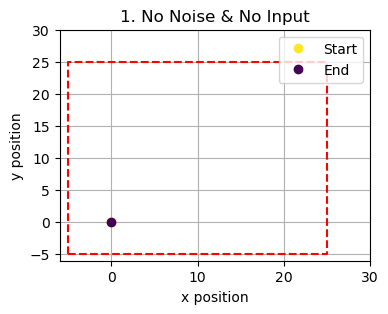

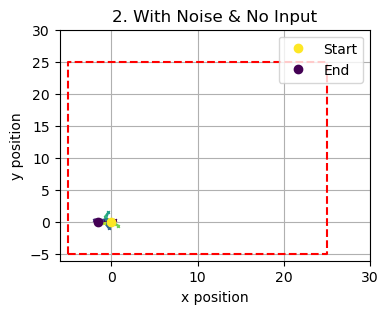

Input Constraints violated for input 0: 2.3 not in [-1  1]
Input Constraints violated for input 1: 1.0499999999999998 not in [-1  1]
Input Constraints violated for input 1: 1.2249999999999999 not in [-1  1]
Input Constraints violated for input 1: 1.4 not in [-1  1]
Input Constraints violated for input 1: 1.575 not in [-1  1]
Output Constraints violated for output 0: 25.710620208891537 not in [-5 25]


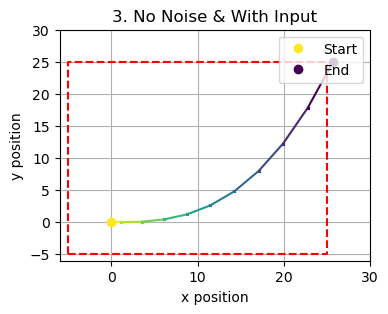

In [3]:
y_box_constraints = np.array([[-5, 25], [-5, 25]])
input_box_constraints = np.array([[-1, 1], [-1, 1]])
system1 = DoubleIntegrator(dt=0.1, y_box_constraints=y_box_constraints, input_box_constraints=input_box_constraints)

# Simulate the system for 10 steps
for i in range(10):
	u = np.array([0, 0])  # No control input
	system1.step(u)
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
system1.plot_trajectory(fig=fig, ax=ax)
# set the title to 1. No Noise & No Input
ax.set_title('1. No Noise & No Input')
plt.show()

noise_profile = (np.zeros(2), np.eye(2)*0.7)  # Mean and covariance for noise
system2 = DoubleIntegrator(dt=0.1, y_box_constraints=y_box_constraints, input_box_constraints=input_box_constraints, noise_profile=noise_profile)
# Simulate the system for 10 steps
for i in range(10):
	u = np.array([0, 0])  # No control input
	system2.step(u)
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
system2.plot_trajectory(fig=fig, ax=ax)
# set the title to 2. With Noise & No Input
ax.set_title('2. With Noise & No Input')
plt.show()

system3 = DoubleIntegrator(dt=1, y_box_constraints=y_box_constraints, input_box_constraints=input_box_constraints)
# Simulate the system for 10 steps
for i in range(10):
	u = np.array([0.23/(i+0.1), 0.175*i])  # Some control input
	system3.step(u)
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
system3.plot_trajectory(fig=fig, ax=ax)
# set the title to 3. No Noise & With Input
ax.set_title('3. No Noise & With Input')
plt.show()

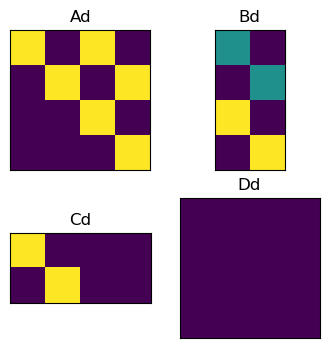

System matrices:
Ad: [[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Bd: [[0.5 0. ]
 [0.  0.5]
 [1.  0. ]
 [0.  1. ]]
Cd: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]]
Dd: [[0. 0.]
 [0. 0.]]


In [4]:
# Lets also print/plot the system matrices
# 2x2 grid
fig, ax = plt.subplots(2, 2, figsize=(4, 4))
ax[0, 0].imshow(system3.Ad, cmap='viridis')
ax[0, 0].set_title('Ad')
ax[0, 1].imshow(system3.Bd, cmap='viridis')
ax[0, 1].set_title('Bd')
ax[1, 0].imshow(system3.Cd, cmap='viridis')
ax[1, 0].set_title('Cd')
ax[1, 1].imshow(system3.Dd, cmap='viridis')
ax[1, 1].set_title('Dd')
# plt.tight_layout()
# remove the x and y ticks
for i in range(2):
	for j in range(2):
		ax[i, j].set_xticks([])
		ax[i, j].set_yticks([])
plt.show()
print("System matrices:")
print("Ad:", system3.Ad)
print("Bd:", system3.Bd)
print("Cd:", system3.Cd)
print("Dd:", system3.Dd)
# Spoiler Alert: I will fairly soon make it clear why I am spending time making this ugly plot

#### Cost and Constraints setup
We will use the default ABCD for the double Integrator, dt=1
**Position Constraints**: between -10 to 10
**Acceleration Constraints**: between -1 to 1

**Initial State & Setpoint Bank** to test from: 
1. $[0, 0, 0, 0]$
2. $[0, 0, 0, 5]$
3. $[5, 5, 0, 0]$
4. $[7, -6, -5, -0.5]$
5. $[-3, 2, 0.5, 0]$
6. $[0, 0, -2.5, -4]$

**Control Horizon**: 4

If there are less than 4 steps to the end of the simulation, the control horizon will be adjusted to fit the remaining steps.

**Sim Steps**: 8

**Cost Function**:
$$ J = \sum_{i=0}^{N-1} \left\lVert x_k - x_{ref}\right\rVert_Q^2  + \left\lVert u_k\right\rVert_R^2 $$

**Quadratic cost matrices**:
$Q = I$, $Qf = 5I$ and $R = 2I$

**Noise:**
We will test 0 mean noise and steady state noise.

$\mu_1 = 0$

$\mu_2 = 0.1$

$\sigma = \begin{bmatrix}
0.1 & 0.05 \\
0.05 & 0.04
\end{bmatrix}$

In [5]:
mu_1 = np.zeros(2)
mu_2 = 0.1*np.ones(2)
sigma = np.array([
    [0.1, 0.05],
	[0.05, 0.04]
])

dt = 1
x01 = np.zeros(4)
x02 = np.array([0, 0, -2, -1])
x03 = np.array([5, 5, 0, 0])
x04 = np.array([7, 6, -5, 0.5])
x05 = np.array([-3, 2, 0.5, 0])
x06 = np.array([0, 0, -2.5, -4])

y_box_constraints = np.array([[-10, 10], [-10, 10]])
input_box_constraints = np.array([[-1, 1], [-1, 1]])
Q = np.eye(4)
Qf = 5*np.eye(4)
R = 2*np.eye(2)
Qy = np.eye(2) # Cost for DeePC & Evaluation
Qfy = 5*np.eye(2)

#### MPC Controller
We will demonstrate an MPC controller to show how this system can be controlled with a standard MPC implementation.

In [6]:
def optimalControlInput(system, setpoint, Q, Qf, R, horizon=5):
	x0 = system.get_state() # current state
	y0 = system.get_y() # current output
	n_input, n_state, n_y = system.n_input, system.n_state, system.n_y
	y_box_constraints = system.y_box_constraints
	input_box_constraints = system.input_box_constraints
	setpoint = np.tile(setpoint, horizon+1) # this is unstacked: [setpoint, setpoint, ..., setpoint], where setpoint = [px, py, vx, vy]

	x = cp.Variable((n_state*(horizon+1))) # this is unstacked: [x0, x1, x2, ..., xN], where xi = [pxi, pyi, vxi, vyi]
	u = cp.Variable((2*horizon)) # this is unstacked: [u0, u1, u2, ..., uN-1], where ui = [uxi, uyi] # 2 is hardcoded since its a double integrator
	y = cp.Variable((n_y*(horizon+1)))  # this is unstacked: [y0, y1, y2, ..., yN], where yi = [pxi, pyi]

	# First, lets setup the cost function
	Q_stacked = sparse.kron(np.eye(horizon), Q).toarray()
	Q_stacked = sla.block_diag(Q_stacked, Qf)
 
	R_stacked = sparse.kron(sparse.eye(horizon), R)
	
	cost = cp.quad_form(x - setpoint, Q_stacked) + cp.quad_form(u, R_stacked)
	# setup the constraints

	Ad = system.Ad
	Bd = system.Bd
	Cd = system.Cd
	Dd = system.Dd

	# TODO: Setup x_k+1 = A*x_k + B*u_k
	constraints = []
	for k in range(horizon):
		x_k = x[n_state * k:n_state * (k + 1)]  # Get state at time k
		x_k_next = x[n_state * (k + 1):n_state * (k + 2)]  # Get state at time k+1
		u_k = u[n_input * k:n_input * (k + 1)]  # Get control input at time k
		y_k = y[n_y * k:n_y * (k + 1)]  # Get output at time k
		
		# State transition constraint: x_k+1 = A_d * x_k + B_d * u_k
		constraints.append(x_k_next == Ad @ x_k + Bd @ u_k)
		# Output constraint: y_k = C_d * x_k + D_d * u_k
		constraints.append(y_k == Cd @ x_k + Dd @ u_k)
  
		# add box constraints for the state
		if y_box_constraints is not None:
			for i in range(system.n_y):
				constraints.append(y_k[i] >= y_box_constraints[i, 0])
				constraints.append(y_k[i] <= y_box_constraints[i, 1])
		# add box constraints for the input
		if input_box_constraints is not None:
			for i in range(system.n_input):
				constraints.append(u_k[i] >= input_box_constraints[i, 0])
				constraints.append(u_k[i] <= input_box_constraints[i, 1])
		
	# Enforce the initial condition: x_0 = x0 (provided state)
	constraints.append(x[:n_state] == x0)

	problem = cp.Problem(cp.Minimize(cost), constraints)
	# Solve the problem
	problem.solve()
	if problem.status not in ["optimal", "optimal_inaccurate"]:
		print("Problem not solved optimally:", problem.status)
		return None, None
	optimal_input = u.value.reshape((horizon, 2))
	return optimal_input

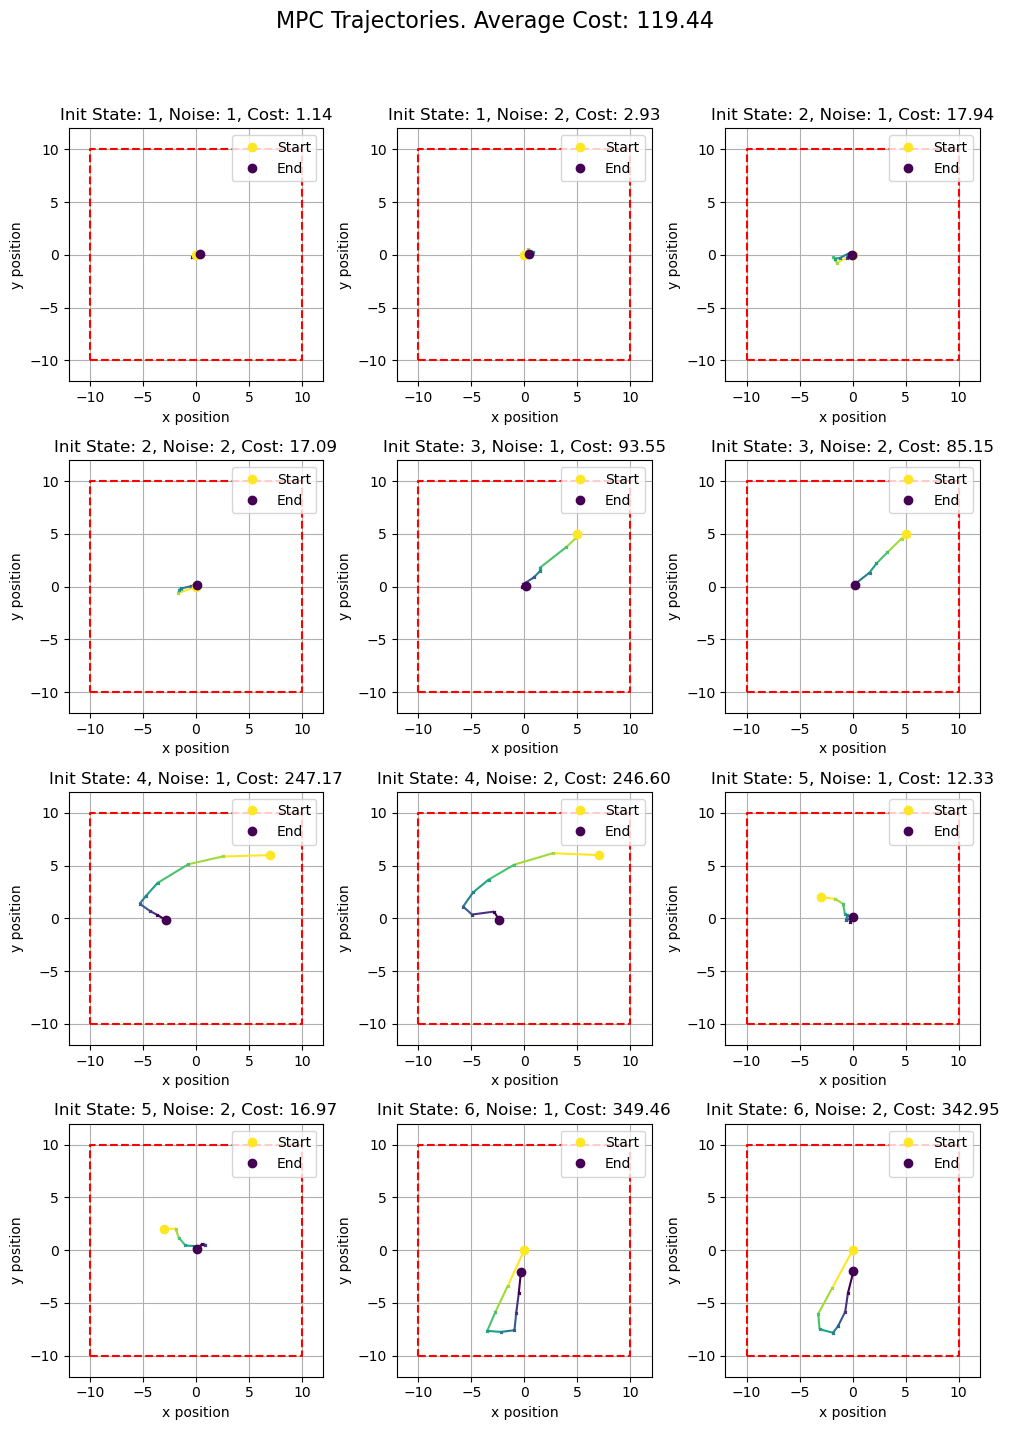

In [7]:
# use x01 as the setpoint
# we have 12 combinations to try, we try from each initial state to the setpoint and with the two different noise profiles
initial_states = [x01, x02, x03, x04, x05, x06]
noise_profiles = [
	(mu_1, sigma),  # Normal noise
	(mu_2, sigma)  # Normal + Steady state noise
]
cost = np.zeros((len(initial_states), len(noise_profiles)))  # To store the cost for each combination
sim_steps = 8  # Number of simulation steps
horizon = 4  # MPC horizon
fig, axs = plt.subplots(4, 3, figsize=(10, 15))
# flatten the axes for easy indexing
axs = axs.flatten()
# create a grid of combinations
for i, initial_state in enumerate(initial_states):
	for j, noise_profile in enumerate(noise_profiles):
		system = DoubleIntegrator(dt=1, initial_state=initial_state, y_box_constraints=y_box_constraints, input_box_constraints=input_box_constraints, noise_profile=noise_profile)

		for k in range(sim_steps):
			
			horizon = min(horizon, sim_steps - k)  # Adjust horizon if we are at the end of the simulation
			optimal_input = optimalControlInput(system, setpoint=x01, Q=Q, Qf=Qf, R=R, horizon=horizon)
			system.step(optimal_input[0])
			# cp.quad_form(x - setpoint, Q_stacked) + cp.quad_form(u, R_stacked)
			cost[i, j] += (system.y - x01[:2]).T @ Qy @ (system.y - x01[:2]) + optimal_input[0].T @ R @ optimal_input[0]
		cost[i, j] += (system.y - x01[:2]).T @ Qfy @ (system.y - x01[:2])  # Add the final cost
		# Plot the trajectory
		system.plot_trajectory(fig=fig, ax=axs[i * len(noise_profiles) + j])
		# Set the title
		axs[i * len(noise_profiles) + j].set_title(f"Init State: {i+1}, Noise: {j+1}, Cost: {cost[i, j]:.2f}")
fig.suptitle(f'MPC Trajectories. Average Cost: {np.mean(cost):.2f}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.savefig('mpc_trajectories.png', dpi=600)
plt.show()
   

Thats fun to see! The MPC controller also handles steady state error well.

#### DeePC Controller & Experimentation
We will now implement a DeePC controller and compare it to the MPC controller.

##### Hankel Structure
The Hankel Structure is defined as:
$
\mathscr{H}_L(u) := 
\begin{pmatrix}
u_1 & \cdots & u_{T - L + 1} \\
\vdots & \ddots & \vdots \\
u_L & \cdots & u_T
\end{pmatrix}
$

The Hankel matrix is just a sliding window of data. By storing the input and output data history, we can approximate capture the behavior of the system.



For example in a linear system:

$x_{k+1} = Ax + Bu$

So we can say:

$\mathcal{X}_f \approx A\mathcal{X}_p + B\mathcal{U}_p$, which allows us to approximate the system dynamics.
$\begin{bmatrix} A & B \end{bmatrix} \approx \mathcal{X_f} \begin{bmatrix} \mathcal{X_p} \\ \mathcal{U_p} \end{bmatrix}^{\dagger}$


In [8]:
def block_hankel(data, L):
	data = data.T
	nmp = data.shape[0] # nmp means the number of n/m/p, aka how many "state"/"input" variables we have
	T = data.shape[1] # T means the number of time steps we have available
	# L is the length of the block hankel matrix, aka context length
	# we need to create:
	# [data[0], data[1], data[2], ... data[T-L]]
	# [data[1], data[2], data[3], ... data[T-L+1]]
	# ...
	# [data[L-1], data[L], data[L+1], ... data[T-1]]
	# we will start by making a 3D tensor of shape (L, T-L+1, nmp)
	block = np.zeros((L, T-L+1, nmp))
	for i in range(L):
		block[i, :, :] = data[:, i:T-L+1+i].T
	# we need to make it such each state var is in the columns, so it should end up being (L*nmp, T-L+1)
	block = block.transpose(0, 2, 1) # this will make it (L, nmp, T-L+1)
	block = block.reshape((L*nmp, T-L+1)) # this will make it (L*nmp, T-L+1)
	return block

Lets actually try extracting the AB matricies with the help of the Hankel structure.

Look back at the `system` variable. This should have data from the Initial State 6 + Steady State Noise case.

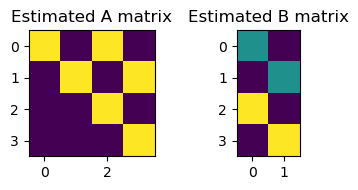

Estimated A matrix:
[[ 1. -0.  1.  0.]
 [ 0.  1.  0.  1.]
 [-0.  0.  1.  0.]
 [-0.  0. -0.  1.]]
Estimated B matrix:
[[ 0.5 -0. ]
 [ 0.   0.5]
 [ 1.   0. ]
 [-0.   1. ]]


In [9]:
u_off_data = np.array(system.input_history)
x_off_data = np.array(system.state_history[:len(u_off_data)])
# We will first estimate the state transition, for which the order is just 1
order = 1
context = 1 # We only need one context step

Hu = block_hankel(u_off_data, order + context)
Hy = block_hankel(x_off_data, order + context)
Up = Hu[:system.n_input*order, :]
Xp = Hy[:system.n_state*order, :]
Uf = Hu[system.n_input*order:, :]
Xf = Hy[system.n_state*order:, :]

# Now we can estimate the state transition matricies
XpUp = np.vstack((Xp, Up))
AB_est = Xf @ nla.pinv(XpUp)
A_est = AB_est[:, :system.n_state]
B_est = AB_est[:, system.n_state:]
# Rounding for better readability
A_est = np.round(A_est, 2)
B_est = np.round(B_est, 2)
# plot the estimated state transition matrices
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
ax[0].imshow(A_est, cmap='viridis')
ax[0].set_title('Estimated A matrix')
ax[1].imshow(B_est, cmap='viridis')
ax[1].set_title('Estimated B matrix')
plt.tight_layout()
plt.show()
print("Estimated A matrix:")
print(A_est)
print("Estimated B matrix:")
print(B_est)

That should look familiar! This demonstrates how the Hankel structure can be used to approximate the system dynamics.

For a linear system, we can easily extract the AB matricies from the Hankel structure. For nonlinear or black box systems, we can still use the Hankel structure to approximate the system dynamics as long as we have wide coverage of the input and output data.

Now, instead of using 

$\begin{bmatrix} A & B \end{bmatrix} \approx \mathcal{X_f} \begin{bmatrix} \mathcal{X_p} \\ \mathcal{U_p} \end{bmatrix}^{\dagger}$
we can *remember* the systems behavior at any given context by using the data with the highest correlation to the current context. 
This is done by 
$
\begin{pmatrix}
U_p \\
Y_p \\
U_f \\
Y_f
\end{pmatrix}
g =
\begin{pmatrix}
u_{\mathrm{ini}} \\
y_{\mathrm{ini}} \\
u \\
y
\end{pmatrix}
$

g is the weight vector that is used to estimate what linear combination of past data is most relevant to the current context.

Since this is a linear system a context length of 1 is sufficient, but for nonlinear or black box systems, we can use a longer context length to capture more of the system's behavior(increasing the context length on linear systems prevents us from extracing the AB matrices, additionally estimating too large of a context length on nonlinear or black box systems can lead to overfitting).

In [10]:
class DeePC:
	def __init__(self, system, T=100, order_estimate=2):
		"""
		DeePC class for Data Efficient Predictive Control (DeePC) implementation.
		Args:
			system: The system to be controlled, should have methods step() and get_state().
			T: Length of the input sequence for offline data collection.
			order_estimate: How much context we believe the system requires
		"""
		self.system = system
		self.n_input = system.n_input  # number of input variables
		self.n_state = system.n_state # number of state variables
		self.n_y = system.n_y  # number of output variables # this is 2 for a 2D system
		self.default_y_box_constraints = self.system.y_box_constraints
		self.default_input_box_constraints = self.system.input_box_constraints
  
		self.T = T  # Length of Offline data collection sequence
		self.order_estimate = order_estimate  # length of the input sequence for the initial condition

		# offline data collection storage
		self.U_off_list, self.Y_off_list = [], []  # Lists to store offline data
		self.U_off_data, self.Y_off_data = None, None  # Numpy arrays to store offline data

		# online data list
		self.U_on_list, self.Y_on_list = [], []  # Lists to store online data
		self.u_ini, self.y_ini = None, None  # Initial condition/context for the online data

		# Hankel matrices
		self.Hu, self.Hy, self.Up, self.Uf, self.Yp, self.Yf = None, None, None, None, None, None
		self.last_horizon = None  # To store the last horizon used for solving

	def disable_box_constraints(self):
		# disable box constraints
		self.system.y_box_constraints = None
		self.system.input_box_constraints = None
  
	def enable_box_constraints(self):
		self.system.y_box_constraints = self.default_y_box_constraints
		self.system.input_box_constraints = self.default_input_box_constraints

  
	def collect_offline_data(self, U=None):
		# first, disable the box constraints so that we can collect data
		self.disable_box_constraints()
		# Collect data for DeePC by creating a random input sequence
		if U is None:
			U = np.random.uniform(-1, 1, (self.T, self.n_input))
		U = np.array(U)

		for u in U:
			# set the state
			self.Y_off_list.append(self.system.y)
			self.system.step(u)
			self.U_off_list.append(u)
		
		self.U_off_data = np.array(self.U_off_list)
		self.Y_off_data = np.array(self.Y_off_list)
  
		# now, we can restore the box constraints
		self.enable_box_constraints()
  
	def step_and_collect(self, u):
		# this will step and collect online data

		self.U_on_list.append(u)
		self.system.step(u)
		self.Y_on_list.append(self.system.y)
  
  
		# we only need the last order_estimate steps of data to get the initial condition/context
		self.U_on_list = self.U_on_list[-self.order_estimate:]
		self.Y_on_list = self.Y_on_list[-self.order_estimate:]
		self.u_ini = np.array(self.U_on_list).flatten()
		self.y_ini = np.array(self.Y_on_list).flatten()

	def build_hankel(self, max_horizon):
		# build the hankel matrices from the offline data
		L = max_horizon + self.order_estimate
		self.Hu = block_hankel(self.U_off_data, L)
		self.Hy = block_hankel(self.Y_off_data, L)

		n_input, n_y = self.n_input, self.n_y
		self.Up = self.Hu[:n_input * self.order_estimate, :]
		self.Uf = self.Hu[n_input * self.order_estimate:, :]
		self.Yp = self.Hy[:n_y * self.order_estimate, :]
		self.Yf = self.Hy[n_y * self.order_estimate:, :]
  
  
	def solve(self, setpoint, horizon, Q=None, Qf=None, R=None, Lg=1e-6, Ly = 1e-6):
		n_input, n_y = self.n_input, self.n_y

		setpoint = np.tile(setpoint, horizon) # this is unstacked: [setpoint, setpoint, ..., setpoint], where setpoint = [px, py, vx, vy]

		# setup a cp variable for x0 rolled N times
		u = cp.Variable((n_input*(horizon)))
		y = cp.Variable((n_y*(horizon)))
		g = cp.Variable((self.Up.shape[1]))
		sigma_y = cp.Variable((self.Yp.shape[0]))

		# First, lets setup the cost function
		Q_stacked = sparse.kron(np.eye(horizon-1), Q).toarray()
		Q_stacked = sla.block_diag(Q_stacked, Qf)
		R_stacked = sparse.kron(sparse.eye(horizon), R)

		cost = cp.quad_form(y - setpoint, Q_stacked) + cp.quad_form(u, R_stacked) + Lg * cp.norm1(g) + Ly * cp.norm1(sigma_y)

		# setup the DeePC constraints
		constraints = [
			self.Up @ g == cp.vec(self.u_ini, order='F'),
			self.Yp @ g + sigma_y == cp.vec(self.y_ini, order='F'),
			self.Uf @ g == u,
			self.Yf @ g == y,
		]

		# add box constraints
		if self.system.y_box_constraints is not None:
			for i in range(self.n_y):
				constraints.append(y[i] >= self.system.y_box_constraints[i, 0])
				constraints.append(y[i] <= self.system.y_box_constraints[i, 1])
		# add box constraints for the input
		if self.system.input_box_constraints is not None:
			for i in range(self.n_input):
				constraints.append(u[i] >= self.system.input_box_constraints[i, 0])
				constraints.append(u[i] <= self.system.input_box_constraints[i, 1])
  
		prob = cp.Problem(cp.Minimize(cost), constraints)
		# prob.solve(solver=cp.SCS)
		prob.solve()

		if prob.status not in ["optimal", "optimal_inaccurate"]:
			print("Problem not solved optimally:", prob.status)
			return None, None


		# Reshape and return
		u_opt = u.value.reshape(horizon, n_input)
		y_opt = y.value.reshape(horizon, n_y)
		return u_opt, y_opt

	def build_and_solve(self, setpoint, horizon=10, Q=None, Qf=None, R=None, Lg=1e-6, Ly = 1e-6):
		# if the horizon is different from the last one, we need to rebuild the hankel matrices
		if self.last_horizon != horizon:
			self.last_horizon = horizon
			self.build_hankel(horizon)
		return self.solve(setpoint, horizon, Q, Qf, R, Lg, Ly)

In [11]:
# Some Hyperparameters to setup
order_estimate = 2  # Initial condition length. Since we are dealing with a double integrator, we need at least 2 steps to get the initial condition
# the reason why we only needed 1 for AB estimation was because we had position and velocity. This time we only have position information
T = 100 # Collect some data points
max_horizon = 5  # Maximum horizon for the DeePC controller

##### Offline Data Collection

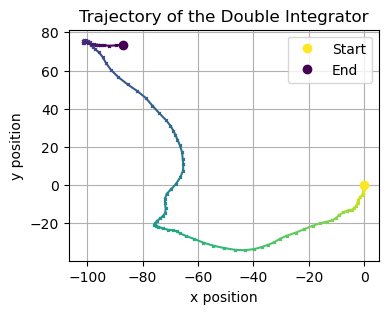

In [12]:
system = DoubleIntegrator(dt=1, y_box_constraints=y_box_constraints, input_box_constraints=input_box_constraints)
# Data Collection parameters
deepc = DeePC(system, T=T, order_estimate=order_estimate) # create an instance of DeePC

# collect data
deepc.collect_offline_data()
# Lets see what that trajectory looked like and see if it was rich enough
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
deepc.system.plot_trajectory(fig=fig, ax=ax, limit_chart=False)

We cannot do too much here to stay within the constraints, but in real life offline data collection can be done by a human operator which should be able to cover the state space of the system.

Lets build and visualize the Hankel structure.

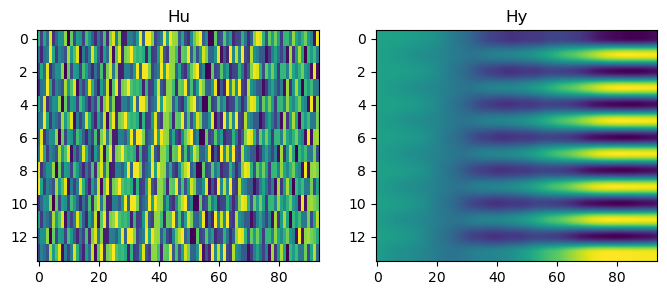

In [13]:
deepc.build_hankel(max_horizon=max_horizon)  # Build the Hankel matrices from the offline data

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
# imshow Hu on the first axis
axs[0].imshow(deepc.Hu, aspect='auto', cmap='viridis')
axs[0].set_title('Hu')
# imshow Hy on the second axis
axs[1].imshow(deepc.Hy, aspect='auto', cmap='viridis')
axs[1].set_title('Hy')
# save this figure as 'deePC_hankel_matrices_imshow.png'
plt.savefig('deePC_hankel_matrices_imshow.png', dpi=600)
plt.show()

Beautiful! This makes sense intuitively, since the hankel matrix is a sliding window, which is why se see so many diagonal structures(the reason why it is structures and not lines is because the input data is a vector so its stacked).

Now we need to collect some initial state data, so we will use an MPC to steer the system to the start

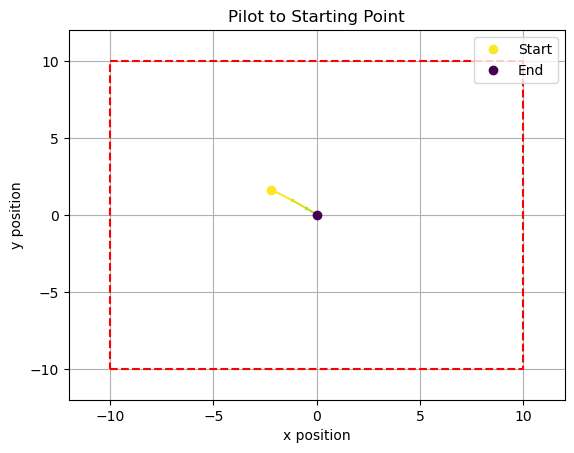

In [14]:
# * Parameters:
des_start = np.array([0, 0, 0, 0])  # Desired starting point before we start DeePC control
N = 20  # Number of steps to take to reach the desired starting point
MPC_horizon = 15  # MPC horizon for the initial condition
store_past = 0 # We do not want to store the trajectories before DeePC control, so we set this to 0
plot = True  # Whether to plot the trajectory or not

def steerDeePCwithMPC(deepcController, mpc_initial_cond, des_start, Q, Qf, R, N, MPC_horizon, store_past, plot):
	# to collect initial condition data, we need to steer the system a bit, we will go to the desired starting point using MPC
	deepcController.system.delete_history()
	deepcController.system.set_state(mpc_initial_cond)
	for i in range(N):
		optimal_input = optimalControlInput(deepcController.system, setpoint=des_start, Q=Q, Qf=Qf, R=R, horizon=min(N - i, MPC_horizon))
		deepcController.step_and_collect(optimal_input[0])
		
	if plot:
		# plot the trajectory
		fig, ax = plt.subplots()
		deepcController.system.plot_trajectory(fig=fig, ax=ax)
		ax.set_title(f'Pilot to Starting Point')
	if store_past is not None:
		deepcController.system.state_history = deepcController.system.state_history[-store_past:]
		deepcController.system.input_history = deepcController.system.input_history[- store_past:]
		deepcController.system.output_history = deepcController.system.y_history[- store_past:]

steerDeePCwithMPC(deepc, x05, des_start, Q, Qf, R, N, MPC_horizon, store_past=0, plot=True)

##### Running DeePC

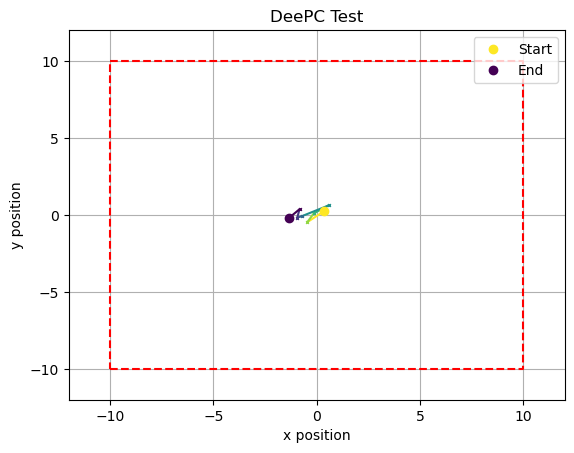

In [15]:
# hyperparameters for DeePC
sim_steps = 8
horizon = 4
Qy = np.eye(2)
Qfy = 5*np.eye(2)
# start by going to the setpoint
steerDeePCwithMPC(deepc, x01, des_start, Q, Qf, R, N, MPC_horizon, store_past=0, plot=False)

# Now that you have u_opt and y_opt, apply the control inputs to the system
# and plot the trajectory

deepc.system.sigma = sigma
setpoint = np.zeros(2)
deepc.system.delete_history()  # Clear the history of the system
for i in range(sim_steps):
	# Solve DeePC
	u_opt, y_opt = deepc.build_and_solve(setpoint, horizon=min(sim_steps - i, horizon), Q=Qy, Qf=Qfy, R=R, Lg=20, Ly=1e4)
	u = u_opt[0]
	# print("u:", u)
	deepc.step_and_collect(u)
fig, ax = plt.subplots()
system.plot_trajectory(fig=fig, ax=ax)
ax.set_title('DeePC Test')
plt.show()

DeePC is does a fair job of staying in place when disturbed by external disturbances. Lets give it the same test as the MPC controller and compare the results.

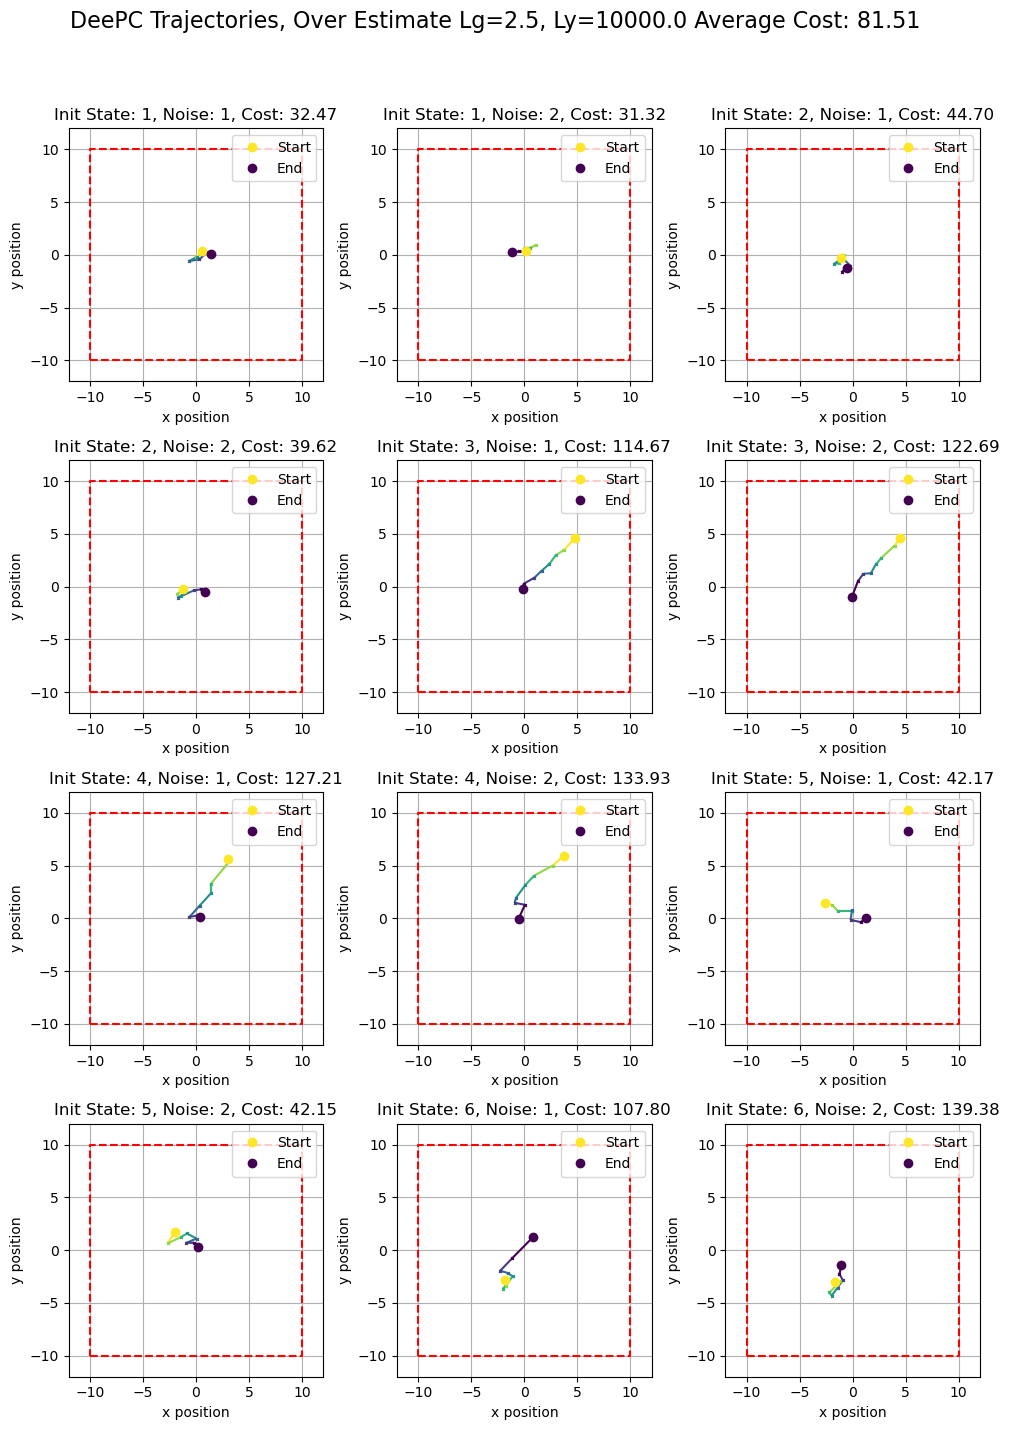

On average, DeePC Solves took 0.01441 seconds to solve the optimization problem.


In [16]:
# * Regularization Hyperparameters
Lg = 2.5		# Model Size regularization
Ly = 1e4	# Model 'Give' Regularization

# use x01 as the setpoint
# we have 12 combinations to try, we try from each initial state to the setpoint and with the two different noise profiles
initial_states = [x01, x02, x03, x04, x05, x06]
noise_profiles = [
	(mu_1, sigma),  # Normal noise
	(mu_2, sigma)  # Normal + Steady state noise
]
cost = np.zeros((len(initial_states), len(noise_profiles)))  # To store the cost for each combination
sim_steps = 8  # Number of simulation steps
horizon = 4  # MPC horizon
fig, axs = plt.subplots(4, 3, figsize=(10, 15))
# flatten the axes for easy indexing
axs = axs.flatten()
# create a grid of combinations
deepc_solve_times = []
for i, initial_state in enumerate(initial_states):
	for j, noise_profile in enumerate(noise_profiles):
		deepc.system.mu, deepc.system.sigma = noise_profile
		steerDeePCwithMPC(deepc, x01, initial_state, Q, Qf, R, N, MPC_horizon, store_past=0, plot=False)

		setpoint = np.zeros(2)
		deepc.system.delete_history()  # Clear the history of the system
		for k in range(sim_steps):
			# Solve DeePC
			start_time = time.time()
			u_opt, y_opt = deepc.build_and_solve(setpoint, horizon=min(sim_steps - k, horizon), Q=Qy, Qf=Qfy, R=R, Lg=Lg, Ly=Ly)
			end_time = time.time()
			deepc_solve_times.append(end_time - start_time)
			u = u_opt[0]
			# print("u:", u)
			deepc.step_and_collect(u)
			cost[i, j] += (system.y - x01[:2]).T @ Qy @ (system.y - x01[:2]) + u.T @ R @ u
		cost[i, j] += (system.y - x01[:2]).T @ Qfy @ (system.y - x01[:2])  # Add the final cost
		# Plot the trajectory
		system.plot_trajectory(fig=fig, ax=axs[i * len(noise_profiles) + j])
		# Set the title
		axs[i * len(noise_profiles) + j].set_title(f"Init State: {i+1}, Noise: {j+1}, Cost: {cost[i, j]:.2f}")
fig.suptitle(f'DeePC Trajectories, Over Estimate Lg={Lg}, Ly={Ly} Average Cost: {np.mean(cost):.2f}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.savefig(f'DeePC_trajectories_{Lg}_{Ly}.png', dpi=600)
plt.show()
deepc_solve_times = np.array(deepc_solve_times)
print(f"On average, DeePC Solves took {np.mean(deepc_solve_times):.5f} seconds to solve the optimization problem.")

This performs fairly well for a linear system with noise, handling steady state error quite well too. Lets see how it performs with a different set of hyperparameters.

Output Constraints violated for output 0: -13.43225212842255 not in [-10  10]
Output Constraints violated for output 0: -17.77677606349224 not in [-10  10]
Output Constraints violated for output 1: -10.05468465309843 not in [-10  10]
Output Constraints violated for output 0: -22.91070533926408 not in [-10  10]
Output Constraints violated for output 1: -12.703616110646866 not in [-10  10]
Output Constraints violated for output 0: -10.151791481768337 not in [-10  10]
Output Constraints violated for output 0: -13.9667452083383 not in [-10  10]
Output Constraints violated for output 0: -19.00166417317773 not in [-10  10]
Output Constraints violated for output 0: -23.872373085439513 not in [-10  10]
Output Constraints violated for output 1: -12.329196618911192 not in [-10  10]
Output Constraints violated for output 0: 11.910723817768403 not in [-10  10]
Output Constraints violated for output 1: 12.703878115827997 not in [-10  10]
Output Constraints violated for output 0: 17.227304290372558 

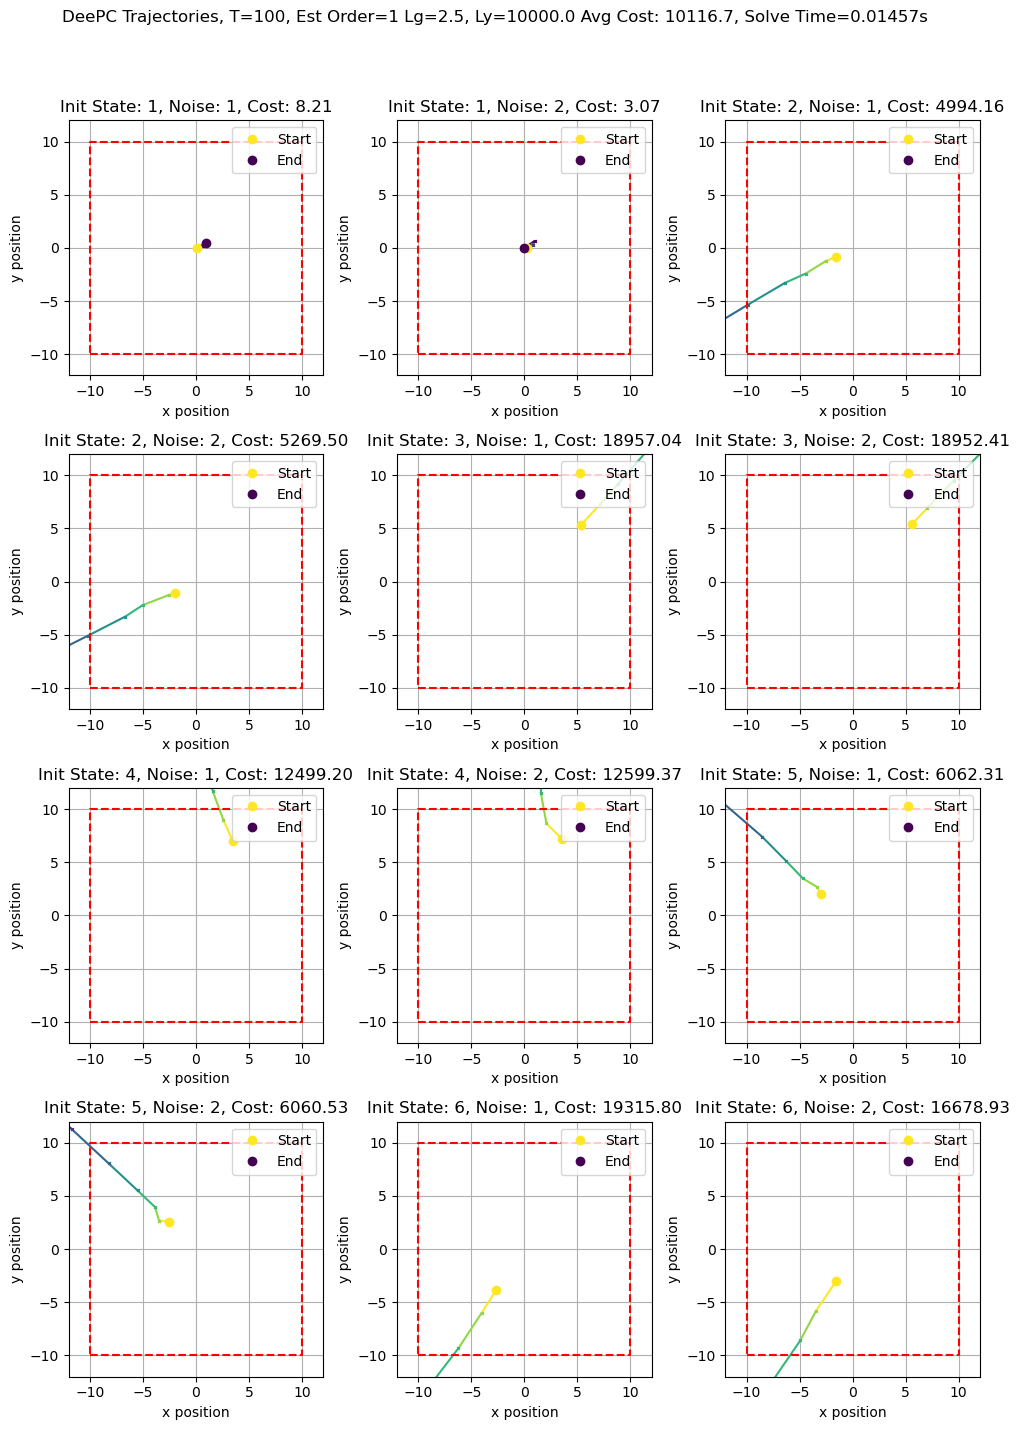

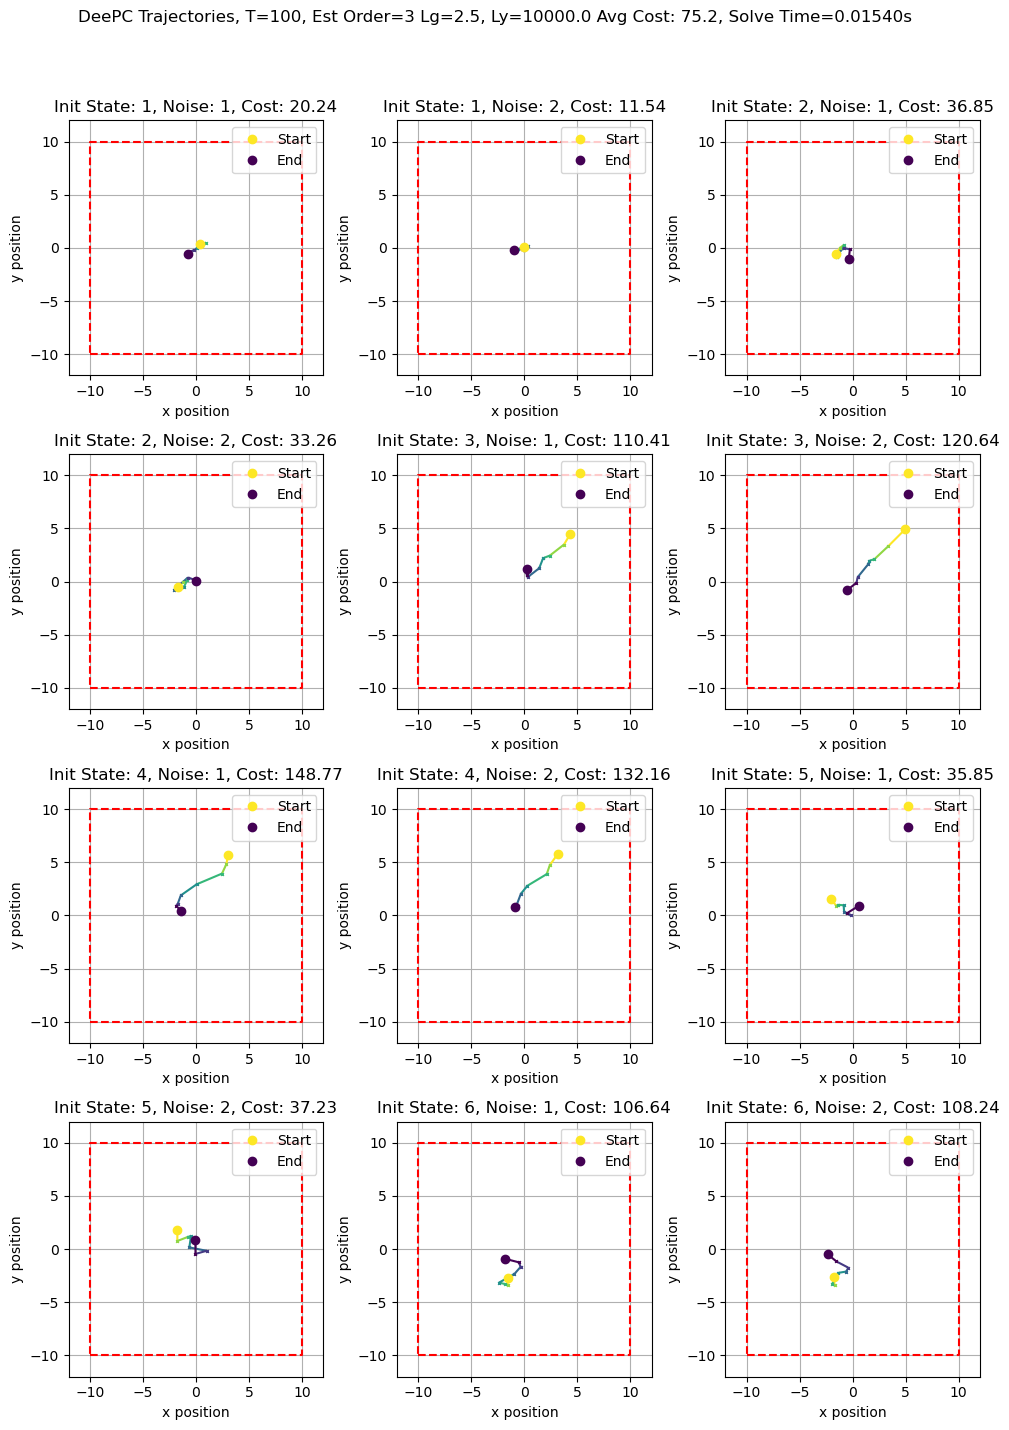

This is expected to fail since the order is too high for the system to handle. Ignore the blank plot shown below.


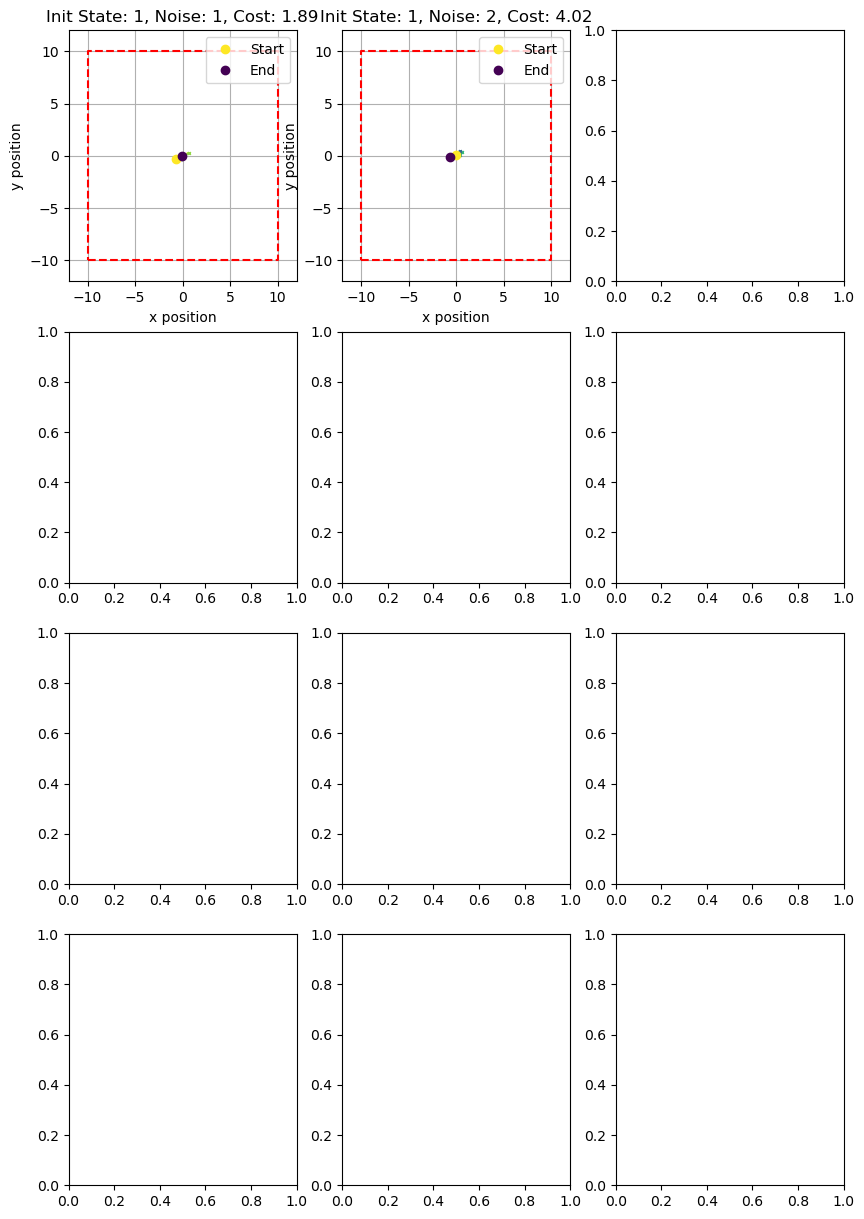

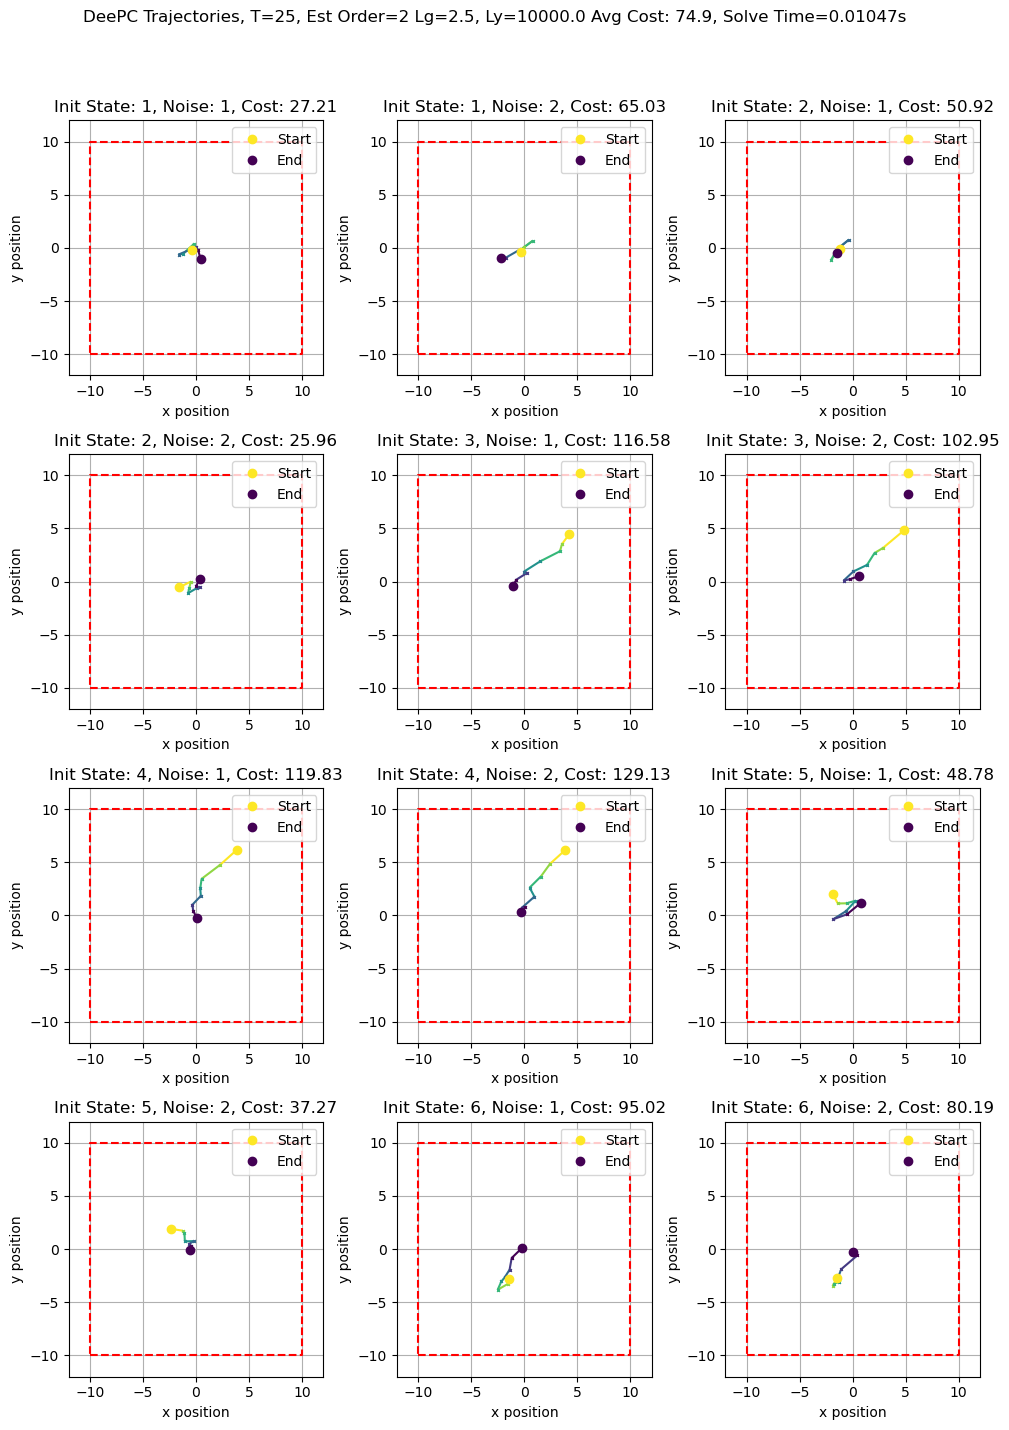

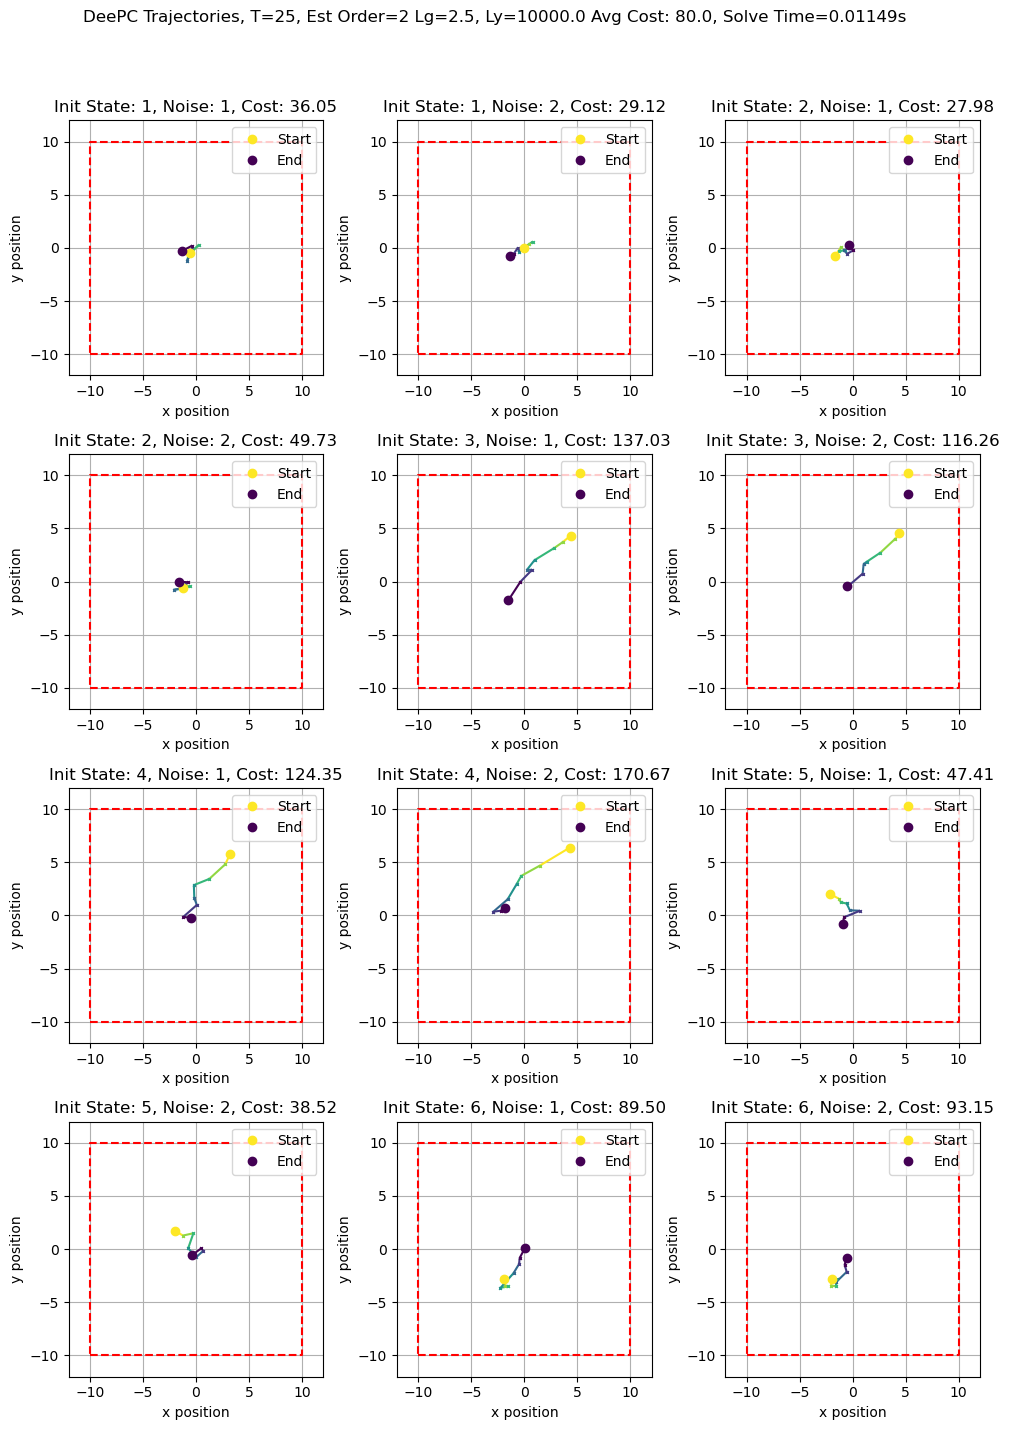

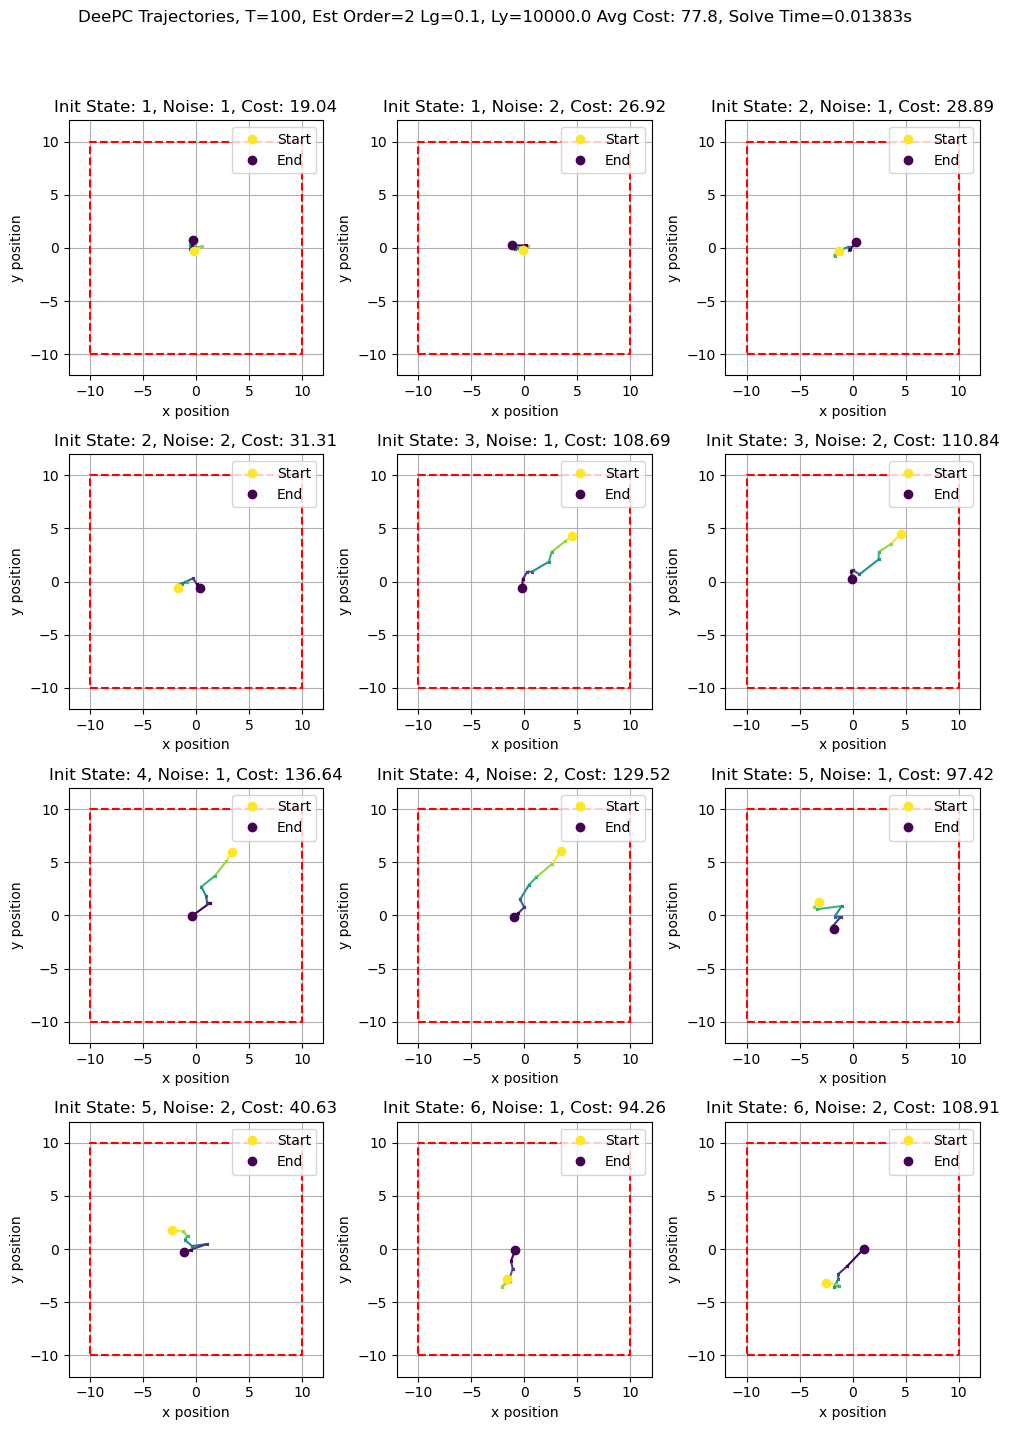

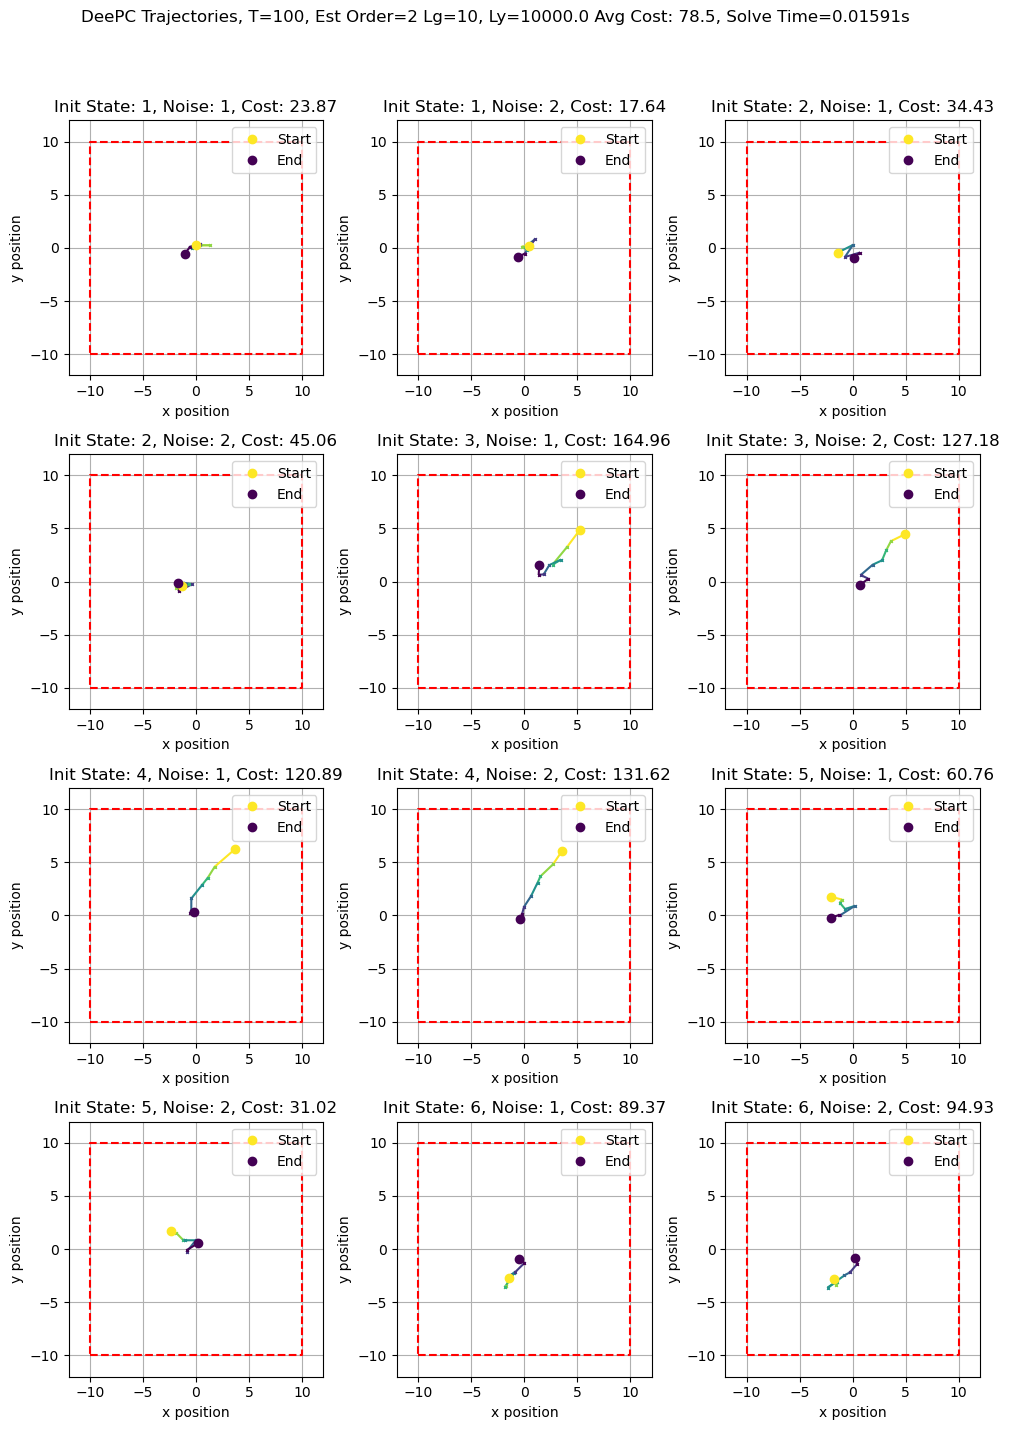

This is expected to fail since this practically allows extremely high values of Sigma. Ignore the blank plot shown below.
Output Constraints violated for output 0: -10.587866121225058 not in [-10  10]
Output Constraints violated for output 0: -11.53552649914989 not in [-10  10]
Output Constraints violated for output 0: -10.204711272457335 not in [-10  10]
Output Constraints violated for output 0: -13.693969190509556 not in [-10  10]
Output Constraints violated for output 0: -13.27032836693171 not in [-10  10]
Output Constraints violated for output 1: -11.81391838968466 not in [-10  10]
Output Constraints violated for output 0: -10.459055106394691 not in [-10  10]
Output Constraints violated for output 1: -14.188368143654895 not in [-10  10]
Output Constraints violated for output 0: -11.28461628245656 not in [-10  10]
Output Constraints violated for output 1: -15.60148687054203 not in [-10  10]
Output Constraints violated for output 0: -12.705079495862242 not in [-10  10]
Output Constra

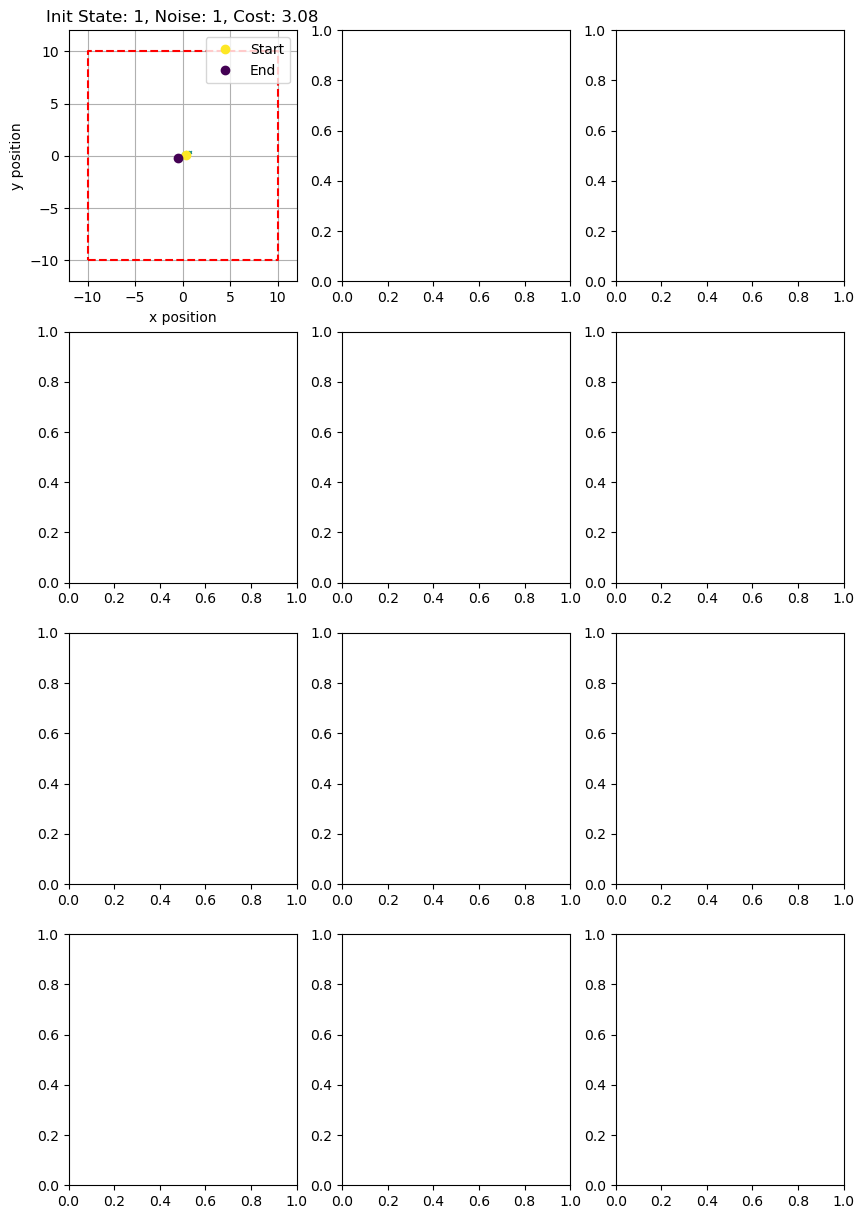

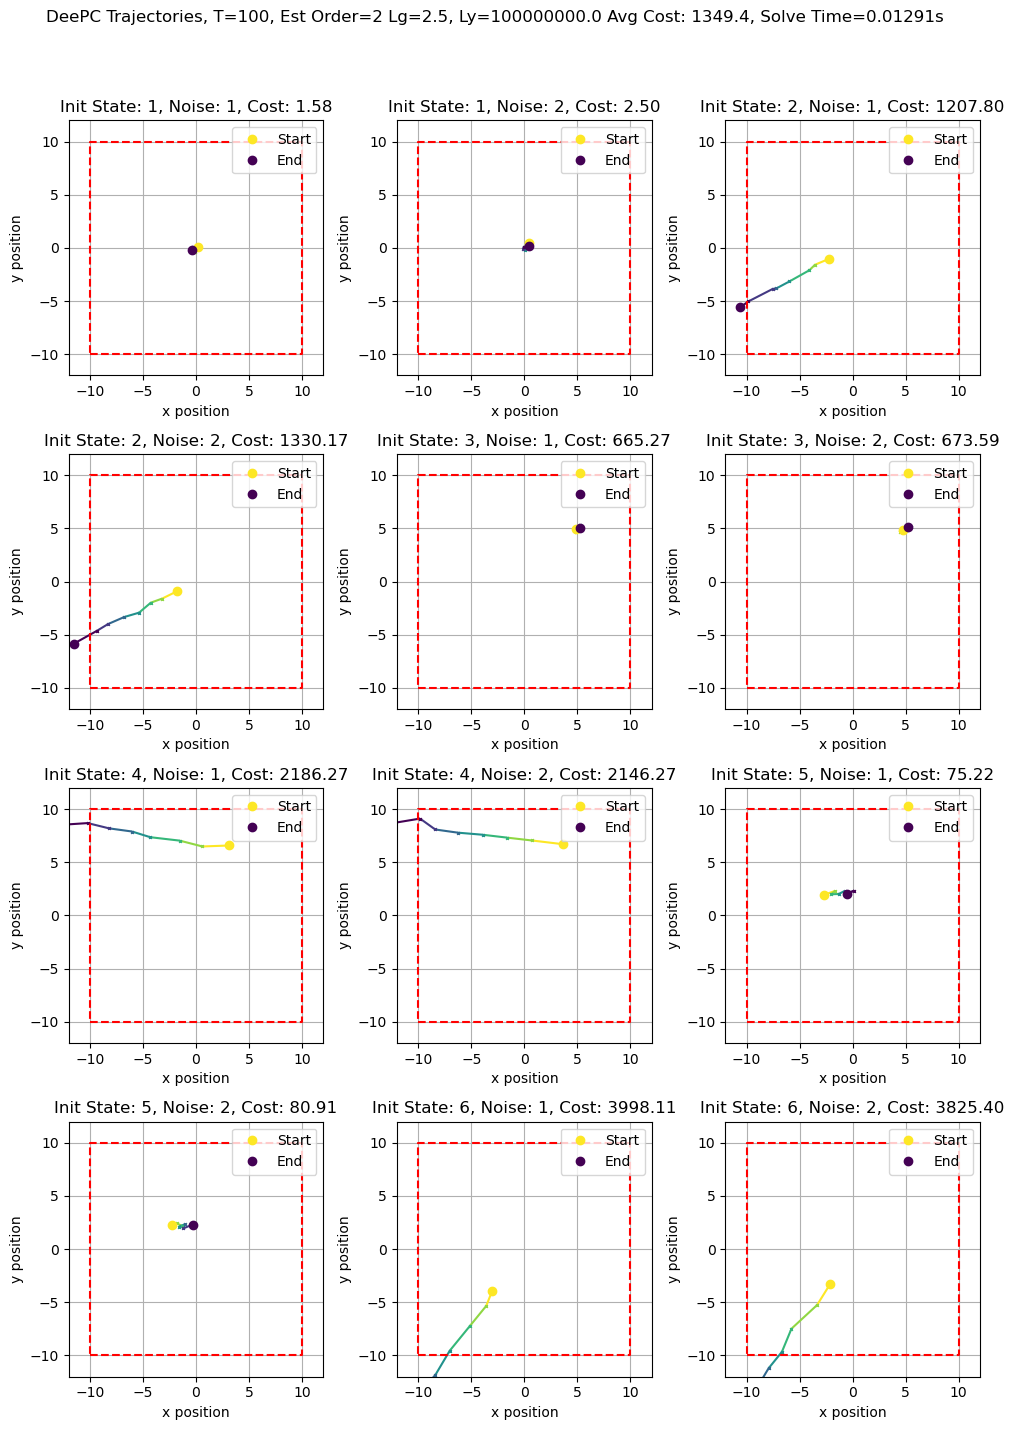

In [ ]:
def testHyperparameters(order_estimate=2, T=100, Lg=2.5, Ly=1e4):
	# Some Hyperparameters to setup

	system = DoubleIntegrator(dt=1, y_box_constraints=y_box_constraints, input_box_constraints=input_box_constraints)
	# Data Collection parameters
	deepc = DeePC(system, T=T, order_estimate=order_estimate) # create an instance of DeePC
	# collect data
	deepc.collect_offline_data()

	# use x01 as the setpoint
	# we have 12 combinations to try, we try from each initial state to the setpoint and with the two different noise profiles
	initial_states = [x01, x02, x03, x04, x05, x06]
	noise_profiles = [
		(mu_1, sigma),  # Normal noise
		(mu_2, sigma)  # Normal + Steady state noise
	]
	cost = np.zeros((len(initial_states), len(noise_profiles)))  # To store the cost for each combination
	sim_steps = 8  # Number of simulation steps
	horizon = 4  # MPC horizon
	fig, axs = plt.subplots(4, 3, figsize=(10, 15))
	# flatten the axes for easy indexing
	axs = axs.flatten()
	# create a grid of combinations
	deepc_solve_times = []
	for i, initial_state in enumerate(initial_states):
		for j, noise_profile in enumerate(noise_profiles):
			deepc.system.mu, deepc.system.sigma = noise_profile
			steerDeePCwithMPC(deepc, x01, initial_state, Q, Qf, R, N, MPC_horizon, store_past=0, plot=False)

			setpoint = np.zeros(2)
			deepc.system.delete_history()  # Clear the history of the system
			for k in range(sim_steps):
				# Solve DeePC
				start_time = time.time()
				u_opt, y_opt = deepc.build_and_solve(setpoint, horizon=min(sim_steps - k, horizon), Q=Qy, Qf=Qfy, R=R, Lg=Lg, Ly=Ly)
				end_time = time.time()
				deepc_solve_times.append(end_time - start_time)
				u = u_opt[0]
				# print("u:", u)
				deepc.step_and_collect(u)
				cost[i, j] += (system.y - x01[:2]).T @ Qy @ (system.y - x01[:2]) + u.T @ R @ u
			cost[i, j] += (system.y - x01[:2]).T @ Qfy @ (system.y - x01[:2])  # Add the final cost
			# Plot the trajectory
			system.plot_trajectory(fig=fig, ax=axs[i * len(noise_profiles) + j])
			# Set the title
			axs[i * len(noise_profiles) + j].set_title(f"Init State: {i+1}, Noise: {j+1}, Cost: {cost[i, j]:.2f}")
	deepc_solve_times = np.array(deepc_solve_times)
	fig.suptitle(f'DeePC Trajectories, T={T}, Est Order={order_estimate} Lg={Lg}, Ly={Ly} Avg Cost: {np.mean(cost):.1f}, Solve Time={np.mean(deepc_solve_times):.5f}s', fontsize=12)
	plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
	plt.savefig(f'DeePC_trajectories_{T}_{order_estimate}_{Lg}_{Ly}.png', dpi=600)
	plt.show()

# We do not need to test the default hyperparameters, since we already did that
# Lets see what happens if we change the order estimate
testHyperparameters(order_estimate=1, T=100, Lg=2.5, Ly=1e4) # Under estimate the order
testHyperparameters(order_estimate=3, T=100, Lg=2.5, Ly=1e4) # Over estimate the order
try:
	testHyperparameters(order_estimate=10, T=100, Lg=2.5, Ly=1e4) # Significantly Over estimate the order
except Exception as e:
	print("This is expected to fail since the order is too high for the system to handle. Ignore the blank plot shown below.")

# Lets try seeing what happens if we change the size of the dataset
testHyperparameters(order_estimate=2, T=25, Lg=2.5, Ly=1e4) # Use very little data

# Lets try seeing what happens if we change the regularization parameters
testHyperparameters(order_estimate=2, T=100, Lg=0.1, Ly=1e4) # Do not heavily regularize the model size
testHyperparameters(order_estimate=2, T=100, Lg=10, Ly=1e4) # Heavily regularize the model size

try:
	testHyperparameters(order_estimate=2, T=100, Lg=2.5, Ly=1e-6) # Do not regularize the model 'give'
except Exception as e:
	print("This is expected to fail since this practically allows extremely high values of Sigma. Ignore the blank plot shown below.")
testHyperparameters(order_estimate=2, T=100, Lg=2.5, Ly=1e8) # Heavily regularize the model 'give'


### Extension: Speeding up DeePC
Now that we have shown how DeePC works, we can speed it up.

If you think about it, for simple linear systems, we can just use the AB matrices to compute the future states and inputs, and this information is already encoded in the Hankel structure. This means, that at least for a linear system, we can use SVD to reduce the dimensionality of the Hankel matrix and speed up the computation. For a nonlinear system, each orthogonal component represents a different behavior of the system, so we can still use SVD to reduce the dimensionality of the Hankel matrix, if we have collected multiple "samples" of the same behavior of the system.

Lets write another version of the DeePC controller that uses SVD to reduce the dimensionality of the Hankel matrix and speed up the computation.

In [18]:
class DeePC_LRA(DeePC):
	def __init__(self, system, T=100, order_estimate=2):
		"""
		DeePC class for Data Efficient Predictive Control (DeePC) implementation.
		Args:
			system: The system to be controlled, should have methods step() and get_state().
			horizon: Prediction/Control horizon for the control inputs.
			T: Length of the input sequence for offline data collection.
			order_estimate: How much context we believe the system requires
		"""
		super().__init__(system, T=T, order_estimate=order_estimate)

	def apply_lra(self, verbose=False):
		# Apply a low-rank approximation to the Hankel matrices
		H_stacked = np.vstack((self.Up, self.Yp, self.Uf, self.Yf))
		U, s, Vh = svd(H_stacked, full_matrices=False)
		min_rank = self.Up.shape[0] + self.Yp.shape[0] + 1
  
		V_l = Vh.T
		# print pre rank shapes
		if verbose:
			print("Pre rank shapes:", self.Up.shape, self.Yp.shape, self.Uf.shape, self.Yf.shape)
		self.Up = self.Up @ V_l
		self.Yp = self.Yp @ V_l
		self.Uf = self.Uf @ V_l	
		self.Yf = self.Yf @ V_l
		# print post rank shapes
		if verbose:
			print("Post rank shapes:", self.Up.shape, self.Yp.shape, self.Uf.shape, self.Yf.shape)
  
	def build_and_solve(self, setpoint, horizon=10, Q=None, Qf=None, R=None, Lg=0.000001, Ly=0.000001):
		# if the horizon is different from the last one, we need to rebuild the hankel matrices
		if self.last_horizon != horizon:
			self.last_horizon = horizon
			self.build_hankel(horizon)
			self.apply_lra()
		return self.solve(setpoint, horizon, Q, Qf, R, Lg, Ly)

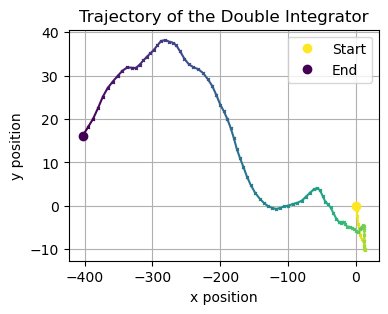

In [19]:
system = DoubleIntegrator(dt=1, y_box_constraints=y_box_constraints, input_box_constraints=input_box_constraints)
# Data Collection parameters
deepc_lra = DeePC_LRA(system, T=T, order_estimate=order_estimate) # create an instance of DeePC

# collect data
deepc_lra.collect_offline_data()
# Lets see what that trajectory looked like and see if it was rich enough
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
deepc_lra.system.plot_trajectory(fig=fig, ax=ax, limit_chart=False)

In [20]:
deepc_lra.build_hankel(max_horizon=max_horizon)  # Build the Hankel matrices from the offline data
deepc_lra.apply_lra(verbose=True)  # Apply low-rank approximation to the Hankel matrices


Pre rank shapes: (4, 94) (4, 94) (10, 94) (10, 94)
Post rank shapes: (4, 28) (4, 28) (10, 28) (10, 28)


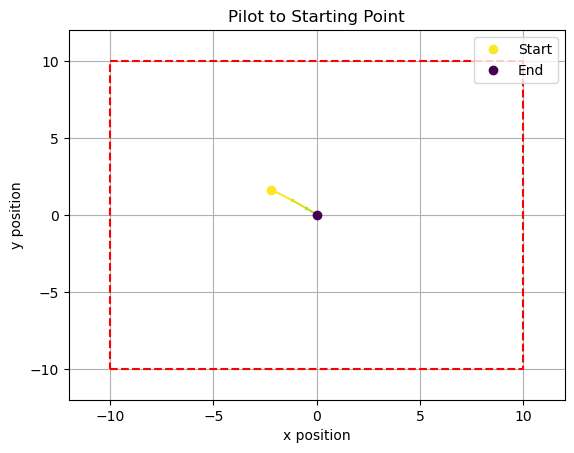

In [21]:
# * Parameters:
des_start = np.array([0, 0, 0, 0])  # Desired starting point before we start DeePC control
N = 20  # Number of steps to take to reach the desired starting point
MPC_horizon = 15  # MPC horizon for the initial condition
store_past = 0 # We do not want to store the trajectories before DeePC control, so we set this to 0
plot = True  # Whether to plot the trajectory or not
steerDeePCwithMPC(deepc_lra, x05, des_start, Q, Qf, R, N, MPC_horizon, store_past=0, plot=True)

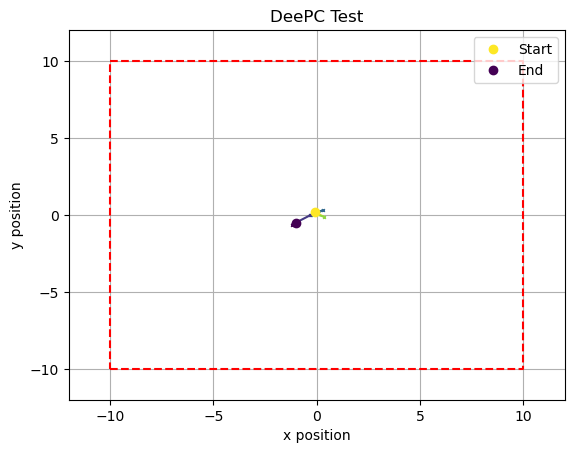

In [22]:
# hyperparameters for DeePC
sim_steps = 8
horizon = 4
Qy = np.eye(2)
Qfy = 5*np.eye(2)
# start by going to the setpoint
steerDeePCwithMPC(deepc_lra, x01, des_start, Q, Qf, R, N, MPC_horizon, store_past=0, plot=False)

# Now that you have u_opt and y_opt, apply the control inputs to the system
# and plot the trajectory

deepc_lra.system.sigma = sigma
setpoint = np.zeros(2)
deepc_lra.system.delete_history()  # Clear the history of the system
for i in range(sim_steps):
	# Solve DeePC
	u_opt, y_opt = deepc_lra.build_and_solve(setpoint, horizon=min(sim_steps - i, horizon), Q=Qy, Qf=Qfy, R=R, Lg=20, Ly=1e4)
	u = u_opt[0]
	# print("u:", u)
	deepc_lra.step_and_collect(u)
fig, ax = plt.subplots()
system.plot_trajectory(fig=fig, ax=ax)
ax.set_title('DeePC Test')
plt.show()

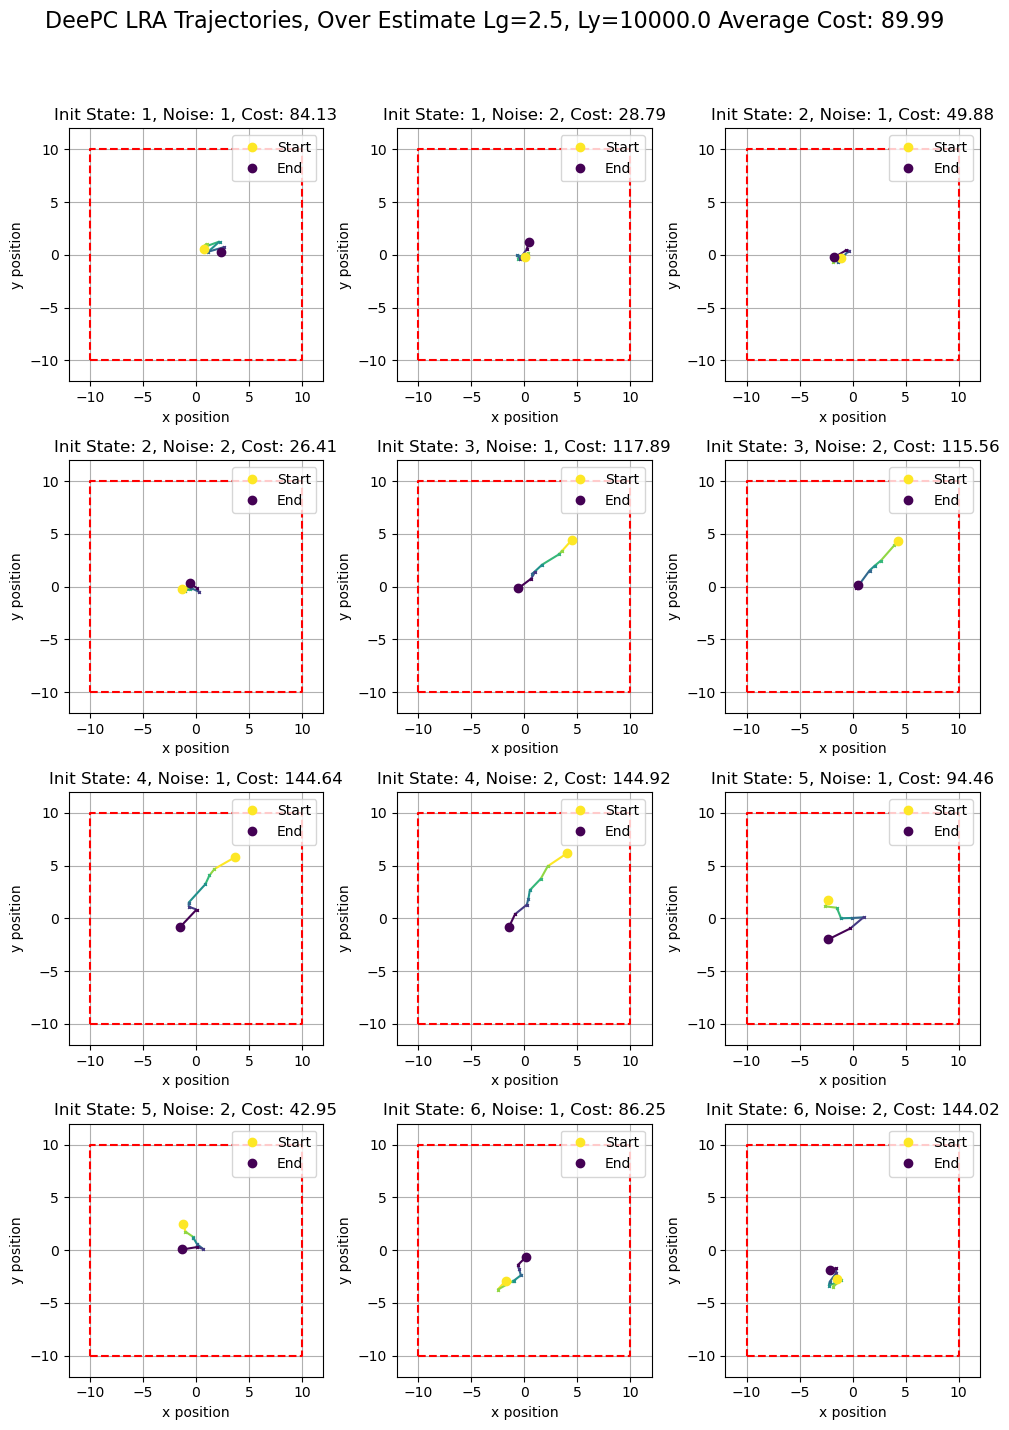

On average, DeePC_LRA took 0.01178 seconds to solve the optimization problem.


In [23]:
# * Regularization Hyperparameters
Lg = 2.5		# Model Size regularization
Ly = 1e4	# Model 'Give' Regularization


# use x01 as the setpoint
# we have 12 combinations to try, we try from each initial state to the setpoint and with the two different noise profiles
initial_states = [x01, x02, x03, x04, x05, x06]
noise_profiles = [
	(mu_1, sigma),  # Normal noise
	(mu_2, sigma)  # Normal + Steady state noise
]
cost = np.zeros((len(initial_states), len(noise_profiles)))  # To store the cost for each combination
sim_steps = 8  # Number of simulation steps
horizon = 4  # MPC horizon
fig, axs = plt.subplots(4, 3, figsize=(10, 15))
# flatten the axes for easy indexing
axs = axs.flatten()
# create a grid of combinations
deepc_lra_solve_times = []
for i, initial_state in enumerate(initial_states):
	for j, noise_profile in enumerate(noise_profiles):
		deepc_lra.system.mu, deepc_lra.system.sigma = noise_profile
		steerDeePCwithMPC(deepc_lra, x01, initial_state, Q, Qf, R, N, MPC_horizon, store_past=0, plot=False)

		setpoint = np.zeros(2)
		deepc_lra.system.delete_history()  # Clear the history of the system
		for k in range(sim_steps):
			# Solve DeePC
			start_time = time.time()
			u_opt, y_opt = deepc_lra.build_and_solve(setpoint, horizon=min(sim_steps - k, horizon), Q=Qy, Qf=Qfy, R=R, Lg=Lg, Ly=Ly)
			end_time = time.time()
			deepc_lra_solve_times.append(end_time - start_time)
			u = u_opt[0]
			# print("u:", u)
			deepc_lra.step_and_collect(u)
			cost[i, j] += (system.y - x01[:2]).T @ Qy @ (system.y - x01[:2]) + u.T @ R @ u
		cost[i, j] += (system.y - x01[:2]).T @ Qfy @ (system.y - x01[:2])  # Add the final cost
		# Plot the trajectory
		system.plot_trajectory(fig=fig, ax=axs[i * len(noise_profiles) + j])
		# Set the title
		axs[i * len(noise_profiles) + j].set_title(f"Init State: {i+1}, Noise: {j+1}, Cost: {cost[i, j]:.2f}")
fig.suptitle(f'DeePC LRA Trajectories, Over Estimate Lg={Lg}, Ly={Ly} Average Cost: {np.mean(cost):.2f}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.savefig(f'DeePC_LRA_trajectories_{Lg}_{Ly}.png', dpi=600)
plt.show()
deepc_lra_solve_times = np.array(deepc_lra_solve_times)
print(f"On average, DeePC_LRA took {np.mean(deepc_lra_solve_times):.5f} seconds to solve the optimization problem.")

Empirically, using the low rank approximation does not seem to have a significant change in performance, but it does seem to speed up the computation, so lets look deeper into this.

In [24]:
# Some Hyperparameters to setup
order_estimate = 2  # Initial condition length. Since we are dealing with a double integrator, we need at least 2 steps to get the initial condition
T = 500 # Collect some data points
max_horizon = 5  # Maximum horizon for the DeePC controller
num_trials = 100

# Offline Data Collection
system1 = DoubleIntegrator(dt=1, y_box_constraints=y_box_constraints, input_box_constraints=input_box_constraints)
system2 = DoubleIntegrator(dt=1, y_box_constraints=y_box_constraints, input_box_constraints=input_box_constraints)
# Data Collection parameters
deepc = DeePC(system1, T=T, order_estimate=order_estimate) # create an instance of DeePC
deepc_lra = DeePC_LRA(system2, T=T, order_estimate=order_estimate) # create an instance of DeePC_LRA

# collect data
deepc.collect_offline_data()
deepc_lra.collect_offline_data()


# Getting the initial condition
true_start = np.array([0, 0, 0, 0])  # Starting point before we start MPC control
des_start = np.array([2, 2, 2, 2])  # Desired starting point after MPC control and before we start DeePC control
N = 20  # Number of steps to take to reach the desired starting point
MPC_horizon = 15  # MPC horizon for the initial condition
store_past = 0 # We do not want to store the trajectories before DeePC control, so we set this to 0

steerDeePCwithMPC(deepc, true_start, des_start, Q, Qf, R, N, MPC_horizon, store_past=0, plot=False)
steerDeePCwithMPC(deepc_lra, true_start, des_start, Q, Qf, R, N, MPC_horizon, store_past=0, plot=False)
deepc.system.delete_history()  # Clear the history of the system
deepc_lra.system.delete_history()  # Clear the history of the system

# Hyperparameters for DeePC
sim_steps = 8
horizon = 4
Qy = np.eye(2)
Qfy = 5*np.eye(2)
noise_profile = (np.zeros(2), 0.01*np.eye(2))  # Normal noise profile
Lg = 2.5		# Model Size regularization
Ly = 1e4	# Model 'Give' Regularization


system1.mu, system1.sigma = noise_profile
system2.mu, system2.sigma = noise_profile
deepc_solve_times, deepc_lra_solve_times = [], []
deepc_costs, deepc_lra_costs = np.zeros((num_trials, sim_steps)), np.zeros((num_trials, sim_steps))  # To store the costs for each trial



setpoints = [[0, 0], [0, 5], [5, 5], [5, -5], [-5, -5], [-5, 5]]
for trial_i in tqdm(range(num_trials)):
	for setpoint_i, setpoint in enumerate(setpoints):
		for i in range(sim_steps):
			start_time = time.time()
			u_opt, y_opt = deepc.build_and_solve(setpoint, horizon=min(sim_steps - i, horizon), Q=Qy, Qf=Qfy, R=R, Lg=Lg, Ly=Ly)
			end_time = time.time()
			deepc_solve_times.append(end_time - start_time)
			u = u_opt[0]
			deepc.step_and_collect(u)
			deepc_costs[trial_i, setpoint_i] += (system1.y - x01[:2]).T @ Qy @ (system1.y - x01[:2]) + u.T @ R @ u

			start_time_lra = time.time()
			u_opt_lra, y_opt_lra = deepc_lra.build_and_solve(setpoint, horizon=min(sim_steps - i, horizon), Q=Qy, Qf=Qfy, R=R, Lg=Lg, Ly=Ly)
			end_time_lra = time.time()
			deepc_lra_solve_times.append(end_time_lra - start_time_lra)
			u_lra = u_opt_lra[0]
			deepc_lra.step_and_collect(u_lra)
			deepc_lra_costs[trial_i, setpoint_i] += (system2.y - x01[:2]).T @ Qy @ (system2.y - x01[:2]) + u_lra.T @ R @ u_lra


100%|██████████| 100/100 [04:14<00:00,  2.54s/it]


In [25]:
# take the mean of the costs on the trials
deepc_costs_mean = np.mean(deepc_costs, axis=0)
deepc_lra_costs_mean = np.mean(deepc_lra_costs, axis=0)
for i, setpoint in enumerate(setpoints):
	print(f"\033[94m{i}. Setpoint {setpoint}:\033[0m")
	print(f"\tDeePC Cost: {deepc_costs_mean[i]:.2f}, DeePC_LRA Cost: {deepc_lra_costs_mean[i]:.2f}")
	if deepc_costs_mean[i] < deepc_lra_costs_mean[i]:
		print(f"\tDeePC outperformed DeePC_LRA by {deepc_lra_costs_mean[i] - deepc_costs_mean[i]:.2f}")
	elif deepc_costs_mean[i] > deepc_lra_costs_mean[i]:
		print(f"\tDeePC_LRA outperformed DeePC by {deepc_costs_mean[i] - deepc_lra_costs_mean[i]:.2f}")

# print the average average costs
print(f"\nAverage DeePC Cost: {np.mean(deepc_costs_mean):.2f}, Average DeePC_LRA Cost: {np.mean(deepc_lra_costs_mean):.2f}")

0. Setpoint [0, 0]:
	DeePC Cost: 166.40, DeePC_LRA Cost: 145.43
	DeePC_LRA outperformed DeePC by 20.97
1. Setpoint [0, 5]:
	DeePC Cost: 89.30, DeePC_LRA Cost: 93.69
	DeePC outperformed DeePC_LRA by 4.40
2. Setpoint [5, 5]:
	DeePC Cost: 348.38, DeePC_LRA Cost: 358.95
	DeePC outperformed DeePC_LRA by 10.58
3. Setpoint [5, -5]:
	DeePC Cost: 351.42, DeePC_LRA Cost: 359.27
	DeePC outperformed DeePC_LRA by 7.85
4. Setpoint [-5, -5]:
	DeePC Cost: 366.10, DeePC_LRA Cost: 382.86
	DeePC outperformed DeePC_LRA by 16.77
5. Setpoint [-5, 5]:
	DeePC Cost: 380.05, DeePC_LRA Cost: 374.79
	DeePC_LRA outperformed DeePC by 5.26

Average DeePC Cost: 212.70, Average DeePC_LRA Cost: 214.37


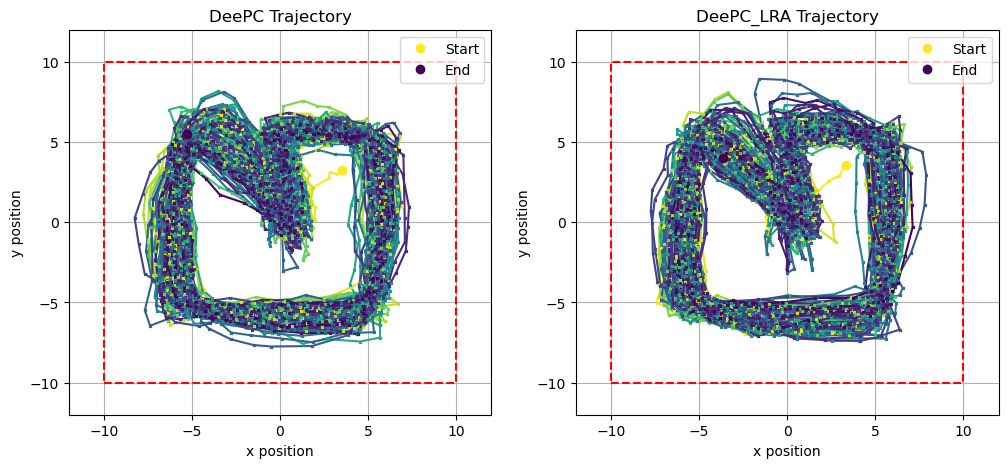

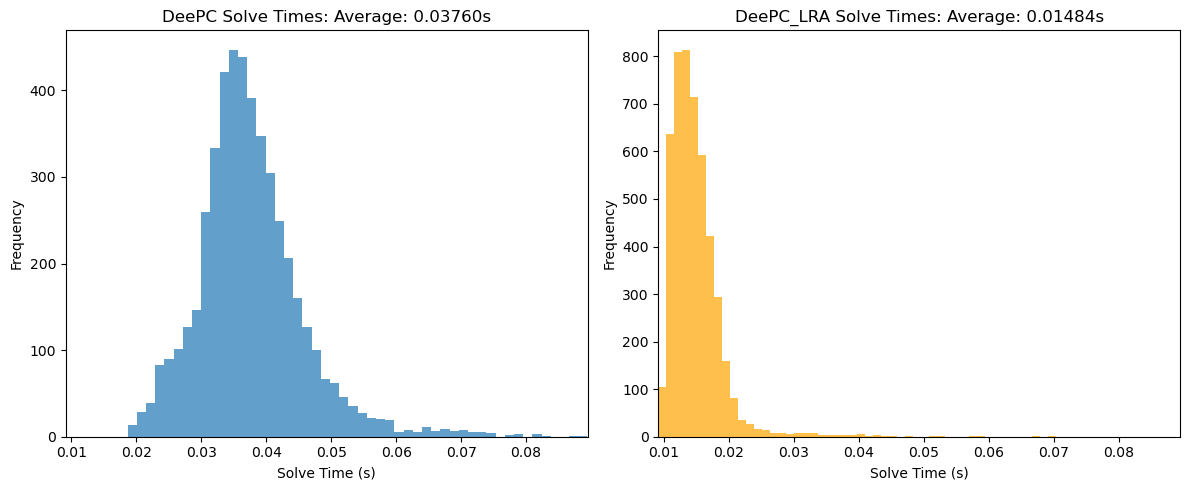

On average, DeePC took 0.03760 seconds to solve the optimization problem.
On average, DeePC_LRA took 0.01484 seconds to solve the optimization problem.
DeePC_LRA took 60.53% less time to solve the optimization problem.


In [26]:
# plot the trajectories and results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# mark each setpoint, so that we can see how the trajectories look like
for setpoint in setpoints:
	axs[0].plot(setpoint[0], setpoint[1], 'ro')  # red dot for deepc
	axs[1].plot(setpoint[0], setpoint[1], 'ro')  # red dot for deepc_lra

deepc.system.plot_trajectory(fig=fig, ax=axs[0], limit_chart=True)
deepc_lra.system.plot_trajectory(fig=fig, ax=axs[1], limit_chart=True)
axs[0].set_title('DeePC Trajectory')
axs[1].set_title('DeePC_LRA Trajectory')
plt.show()

# constrain the axes so that we can see the difference well
max_time = max(max(deepc_solve_times), max(deepc_lra_solve_times))
min_time = min(min(deepc_solve_times), min(deepc_lra_solve_times))
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# plot the solve times for DeePC
# plot the histogram of the solve times for DeePC
ax[0].hist(deepc_solve_times, bins=50, alpha=0.7)
ax[0].set_title(f'DeePC Solve Times: Average: {np.mean(deepc_solve_times):.5f}s')
ax[0].set_xlabel('Solve Time (s)')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim([min_time, max_time])  # Set x-limits to the max solve time
# plot the histogram of the solve times for DeePC_LRA
ax[1].hist(deepc_lra_solve_times, bins=50, alpha=0.7, color='orange')
ax[1].set_title(f'DeePC_LRA Solve Times: Average: {np.mean(deepc_lra_solve_times):.5f}s')
ax[1].set_xlabel('Solve Time (s)')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim([min_time, max_time])  # Set x-limits to the max solve time
plt.tight_layout()
plt.savefig('deePC_solve_times.png', dpi=600)
plt.show()

print(f"On average, DeePC took {np.mean(deepc_solve_times):.5f} seconds to solve the optimization problem.")
print(f"On average, DeePC_LRA took {np.mean(deepc_lra_solve_times):.5f} seconds to solve the optimization problem.")
print(f"DeePC_LRA took {100 * (np.mean(deepc_solve_times) - np.mean(deepc_lra_solve_times)) / np.mean(deepc_solve_times):.2f}% less time to solve the optimization problem.")

##### Interpreting the Results
Using a Low Rank Approximation speeds up the DeePC solver over 50% in the above tests. However there are two important notes to make:

Performance highly depends on the "rank" of the system. It is significantly easier to speed up a linear system than a system with a complex behavior, since the linear system has a low rank.

Collecting more data will slow down a normal DeePC controller by a fair bit, since the implicit dynamics model is a lot larger. It will not significantly slow down the low rank DeePC controller, since the SVD will reduce the dimensionality of the Hankel matrix. The only downside is that the SVD computation is expensive, but it can be done offline unless the horizon is changing frequently.

Collecting more data helps the DeePC controller to better approximate the system dynamics, and the Low Rank Controller allows you to collect more data without significantly slowing down the controller.

